# Does the macroeconomy exhibit recurring patterns? —— A MacroScope Model to quantify the business cycle

**Team Member**
| Name | Student Number |
| :----: | :--------------: |
| Ruiyang Ge | 2301212326 |
| Yuhang Qin | 2301212373 |
| Yuyang Zhang | 2301212424 |
| Yichao Chen | 2301212314 |
| Guanzhou Jiang | 2301212234 |

Last week, we completed the writing of the backtesting framework, which allows us to backtest strategies with known positions. The next step is to collect data according to the previous framework to compare the similarity of macroeconomic variables between each pair of months. We have selected the following dimensions for this purpose:

| Dimension | Input variable |
| :----: | :--------------: |
| Liquidity | Social Financing |
| Inflation | CPI |
| Economic Prosperity | PMI |
| Overseas Liquidity | 10Y Rate-Tips |
| Monetary Conditions | R007/DR007/The Central Bank's Liquidity Injection |

Among these datasets, some possess high-frequency data, such as the 10-Year Rate-TIPS, R007/DR007, and the Central Bank's Liquidity Injection, which are available on a daily or weekly basis. However, the remainder of the data is predominantly monthly. Since we intend to employ the Dynamic Time Warping (DTW) algorithm to calculate the similarity between each pair of months, it is imperative that we utilize high-frequency data. One approach is to identify high-frequency proxy variables for the low-frequency data and directly use these proxies for analysis. This method is relatively straightforward, and we will retain this approach as a viable option. Another method involves using high-frequency data to fit the variables we require, thereby obtaining high-frequency fitted data. This week, we have performed fitting for several variables, including PMI, Social Financing, and CPI (the data for Social Financing and CPI are still being processed but are largely complete, hence not yet uploaded; only the methodology for PMI is shared here). **If there is room for improvement in our methodology, we welcome your constructive criticism and suggestions.**

Initially, we consulted academic papers and research reports (Guotai Junan, 2021) and discovered that the PMI (Purchasing Managers' Index) formula is as follows: 


Manufacturing PMI = New Orders Index × 30% + Production Index × 25% + Employment Index × 20% + (100 - Suppliers' Delivery Times Index) × 15% + Main Raw Materials Inventory Index × 10%


 Consequently, a significant portion of the PMI is related to industrial production and demand. Therefore, we selected the following indicators from the Wind database: `Operating Rate: Rebar - Major Steel Mills`, 

 `Operating Rate: Automotive Tires (Semi-Steel)`, 

 `Load Rate: Polyester Staple Fiber`, 

 `Industrial Chain Load Rate: Purified Terephthalic Acid - Jiangsu and Zhejiang Looms`,

`Transaction Area: Commercial Housing in 30 Large and Medium-Sized Cities`, 

`Transaction Land Area in 100 Large and Medium-Sized Cities`, 

`Futures Settlement Price (Active Contract): Coking Coal`, 

`Shanghai Price: Rebar (HRB400E, 20mm)`.


# Data preparation

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df_weekly = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet3')
df_weekly['日期'] = pd.to_datetime(df_weekly['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_weekly.set_index('日期', inplace=True)
df_weekly = df_weekly.drop(columns=['指标名称'])
df_weekly = df_weekly.fillna(method='ffill')
df_weekly = df_weekly.resample('W').mean() # resample to weekly data

In [2]:
df_weekly

,中国:开工率:螺纹钢:主要钢厂:周:结束日7,中国:开工率:汽车轮胎(半钢胎):周:结束日7,中国:装置负荷率:涤纶短纤:周:结束日7,中国:产业链负荷率:精对苯二甲酸:江浙织机:周:平均值:结束日7,中国:30大中城市:成交面积:商品房:周:平均值:结束日7,中国:100大中城市:成交土地占地面积:当周值,期货结算价(活跃合约):焦煤:周:平均值:结束日7,"上海:价格:螺纹钢(HRB400E,20mm):周:平均值:结束日7"
日期,,,,,,,,
2015-03-01,64.60,41.23,49.00,10.000000,21.714363,730.5604,728.333333,2345.0
2015-03-08,67.00,59.59,51.00,20.000000,38.410723,1054.5874,720.600000,2336.0
2015-03-15,70.60,63.48,55.00,45.000000,52.876438,2351.5698,718.200000,2308.0
2015-03-22,74.18,67.21,55.00,65.000000,53.886760,2417.7039,711.600000,2384.0
2015-03-29,76.10,69.09,69.00,70.000000,60.144075,977.0021,701.200000,2468.0
...,...,...,...,...,...,...,...,...
2025-01-26,32.12,70.30,74.33,22.950000,25.171454,1607.4799,1143.600000,3400.0
2025-02-02,32.12,19.84,74.33,22.950000,1.954117,222.6028,1134.500000,3400.0
2025-02-09,34.12,29.38,69.86,12.093333,9.387271,1063.1971,1126.666667,3400.0


In [3]:
df_monthly = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet3')
df_monthly['日期'] = pd.to_datetime(df_monthly['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_monthly.set_index('日期', inplace=True)
df_monthly.drop(columns=['指标名称'], inplace=True)
df_monthly = df_monthly.resample('M').mean()
df_monthly = df_monthly.fillna(method='ffill') #resample to monthly data

In [4]:
df_pmi = pd.read_excel(r'C:\QPS\PMI.xlsx',skiprows=1,sheet_name='Sheet2')
df_pmi['日期'] = pd.to_datetime(df_pmi['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_pmi.set_index('日期', inplace=True)
df_pmi.drop(columns=['指标名称'], inplace=True)
df_pmi = df_pmi.resample('M').last()
df_pmi = df_pmi[df_pmi.index>'2015-2-28'] #read pmi data from 2015-3-1

In [5]:
df_pmi.head() # Industry PMI, New Orders PMI and Production PMI

,中国:制造业PMI,中国:制造业PMI:生产,中国:制造业PMI:新订单
日期,,,
2015-03-31,50.1,52.1,50.2
2015-04-30,50.1,52.6,50.2
2015-05-31,50.2,52.9,50.6
2015-06-30,50.2,52.9,50.1
2015-07-31,50.0,52.4,49.9


In [6]:
# Prepare the data for the model
df_x = df_monthly.iloc[:-1,:]
# df_x = pd.concat([df_x,df_pmi.shift(1)],axis=1)
df_x = df_x.dropna()
df_y = df_pmi.copy()
display(df_x)
display(df_y)

,中国:开工率:螺纹钢:主要钢厂:周:结束日7,中国:开工率:汽车轮胎(半钢胎):周:结束日7,中国:装置负荷率:涤纶短纤:周:结束日7,中国:产业链负荷率:精对苯二甲酸:江浙织机:周:平均值:结束日7,中国:30大中城市:成交面积:商品房:周:平均值:结束日7,中国:100大中城市:成交土地占地面积:当周值,期货结算价(活跃合约):焦煤:周:平均值:结束日7,"上海:价格:螺纹钢(HRB400E,20mm):周:平均值:结束日7"
日期,,,,,,,,
2015-03-31,70.4960,60.1200,55.800000,42.000000,45.406472,1506.284720,715.986667,2368.200000
2015-04-30,78.6850,71.0575,73.000000,78.500000,58.711548,972.195975,671.350000,2335.250000
2015-05-31,81.5860,73.6300,77.600000,78.200000,70.380982,1515.646940,676.440000,2264.900000
2015-06-30,81.3750,74.2125,75.250000,71.000000,72.155055,2023.830325,684.162500,2097.375000
2015-07-31,77.2475,70.9100,64.000000,66.925000,72.025630,2007.574200,640.300000,1925.000000
...,...,...,...,...,...,...,...,...
2024-09-30,36.6740,78.6640,70.640000,70.386133,22.910594,1672.396260,1298.173333,3298.266667
2024-10-31,42.7975,77.5825,75.513333,77.096000,29.560534,1486.924450,1440.087500,3619.000000
2024-11-30,41.7975,79.1975,75.702500,76.679375,38.200970,2138.159800,1320.325000,3502.000000


,中国:制造业PMI,中国:制造业PMI:生产,中国:制造业PMI:新订单
日期,,,
2015-03-31,50.1,52.1,50.2
2015-04-30,50.1,52.6,50.2
2015-05-31,50.2,52.9,50.6
2015-06-30,50.2,52.9,50.1
2015-07-31,50.0,52.4,49.9
...,...,...,...
2024-09-30,49.8,51.2,49.9
2024-10-31,50.1,52.0,50.0
2024-11-30,50.3,52.4,50.8


# XGBoost Model to fit PMI

mean absolute error: 0.39666633962470815


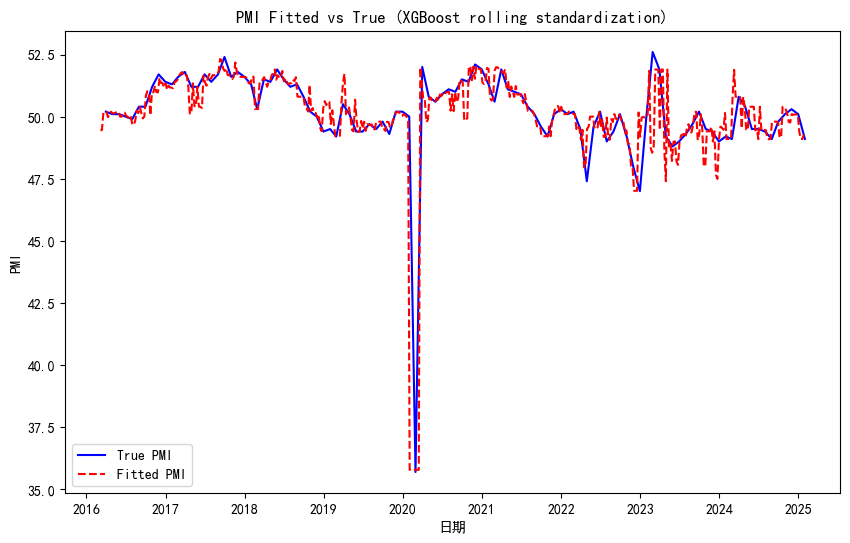

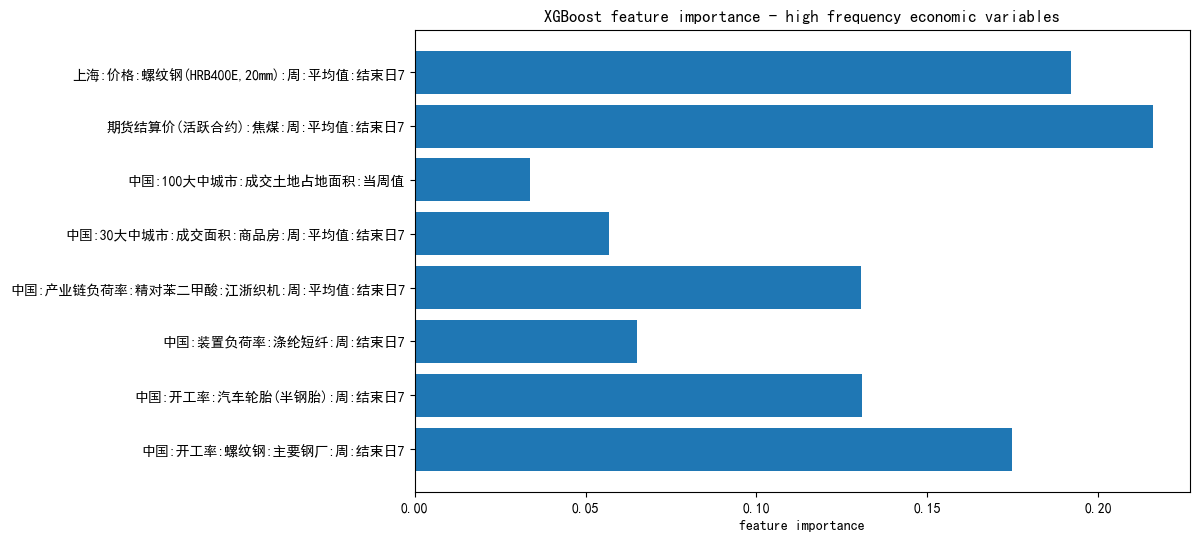

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# set the style of the plots
plt.rcParams['font.sans-serif'] = ['SimHei']

# Rolling training and prediction, rolling window size = 12
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(df_x.shape[1])

# store the predicted and true values
pred_dates = []
true_dates = []

# rolling window training and prediction
for i in range(window_size, len(df_y)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = df_x.iloc[i - window_size:i+1, :]  # high frequency economic variables Monthly data
    y_train = df_y['中国:制造业PMI'].iloc[i - window_size:i+1]  # Monthly PMI data
    
    # get the next month's data as the test set
    next_month = df_y.index[i] #test data
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # find the weekly data of the next month
    df_weekly_filtered = df_weekly[(df_weekly.index >= next_month_start_date) & (df_weekly.index <= next_month)]
    
    # standardize the training set
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # rolling standardization
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # fit the XGBoost model
    X_test = df_weekly_filtered  
    y_test = df_y['中国:制造业PMI'].iloc[i:i+1]  


    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # make sure the training set and test set are not empty
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:

        model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # fit the model and make predictions
        y_pred_scaled = model.predict(X_test_scaled)
        
        # rescale the predicted and true values
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        

        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])


        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # importances of the features
        feature_importances += model.feature_importances_

# calculate the mean absolute error
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"mean absolute error: {mae}")

# calculate the feature importances
feature_importances /= (len(df_y) - window_size)

# get the feature names
feature_names = df_x.columns


df_pred = pd.DataFrame({'Date': pred_dates, 'Predicted PMI': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, 'Predicted PMI': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, 'True PMI': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, 'True PMI': true_values_2})

# p
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['True PMI'], label='True PMI', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['Predicted PMI'], label='Fitted PMI', color='red', linestyle='--')
plt.xlabel('日期')
plt.ylabel('PMI')
plt.title('PMI Fitted vs True (XGBoost rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('feature importance')
plt.title('XGBoost feature importance - high frequency economic variables')
plt.show()

In [13]:
df_predicted_pmi = df_pred.copy()
df_predicted_pmi

,Date,Predicted PMI
0,2016-03-06,49.459114
1,2016-03-13,49.458889
2,2016-03-20,50.164883
3,2016-03-27,50.199635
4,2016-04-03,50.199623
...,...,...
460,2024-12-29,50.099258
461,2025-01-05,49.385448
462,2025-01-12,49.102264
463,2025-01-19,49.100449


# PMI monthly DTW distance

In [14]:
df_pred

,Date,Predicted PMI
0,2016-03-06,49.459114
1,2016-03-13,49.458889
2,2016-03-20,50.164883
3,2016-03-27,50.199635
4,2016-04-03,50.199623
...,...,...
460,2024-12-29,50.099258
461,2025-01-05,49.385448
462,2025-01-12,49.102264
463,2025-01-19,49.100449


In [15]:
from fastdtw import fastdtw
import matplotlib.dates as mdates
monthly_data = df_pred.groupby(pd.Grouper(key='Date', freq='M'))

# Define the function to calculate DTW distance
def calculate_dtw(series1, series2):
    # Calculate the DTW distance if both series have more than 1 point
    if len(series1) > 1 and len(series2) > 1:
        distance, _ = fastdtw(series1, series2)
        return distance
    else:
        return None  # Return None if the series is too short

# Initialize an empty dictionary to store the results
dtw_results = {}

# Loop over each variable (column) in the DataFrame, and calculate DTW for each
for i, variable in enumerate(df_pred.columns[1:]):  # Skip the 'date' column
    dtw_distances = []
    month_labels = []
    
    # Loop through each month starting from the second month (to compare with previous months)
    for end_month, end_data in monthly_data:
        if end_month <= pd.Timestamp('2025-01-31'):  # We want to compare until January 2025
            if end_month == pd.Timestamp('2025-01-31'):  # We are interested in January 2025
                # Get the time series for January 2025
                series1 = end_data[variable].values
                
                for start_month, start_data in monthly_data:
                    if start_month < end_month:  # Only compare with previous months
                        # Get the time series for the previous months
                        series2 = start_data[variable].values
                        distance = calculate_dtw(series1, series2)
                        if distance is not None:
                            dtw_distances.append(distance)
                            month_labels.append(start_month.strftime('%Y-%m'))  # Format the month label as 'yyyy-mm'

    # Add the results to the dictionary with the variable name as the key
    dtw_results[variable] = pd.Series(dtw_distances, index=month_labels)

# Convert the dictionary to a DataFrame
dtw_df = pd.DataFrame(dtw_results)

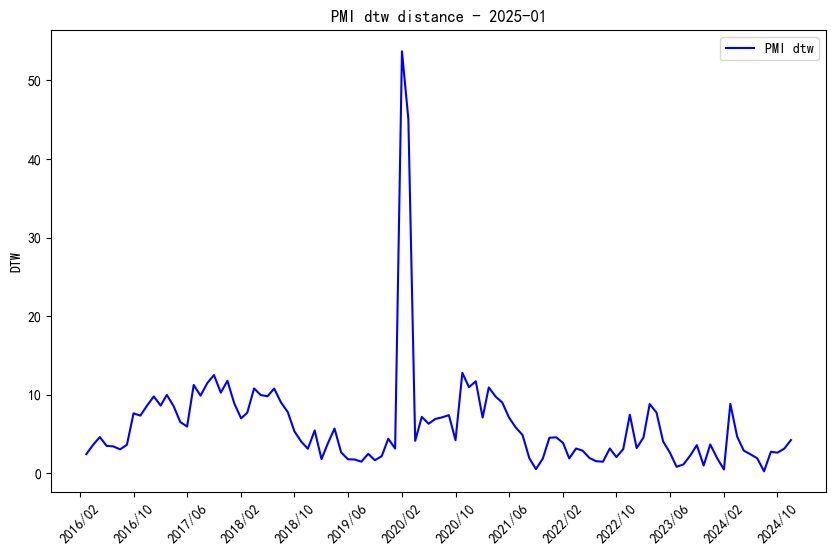

In [16]:
dtw_df.index = pd.to_datetime(dtw_df.index)

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(dtw_df.index, dtw_df, label='PMI dtw', color='blue', linestyle='-')
plt.ylabel('DTW')
plt.title('PMI dtw distance - 2025-01')
plt.legend()
# 设置日期格式：每三个月显示一次
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))  # 每个月显示年份-月份
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))  # 每三个月显示一次标签
# 自动旋转日期标签以避免重叠
plt.xticks(rotation=45)
plt.show()

We can select the k months (k=10) with the closest DTW distance to January 2025 and intuitively assess the degree of similarity among these months.

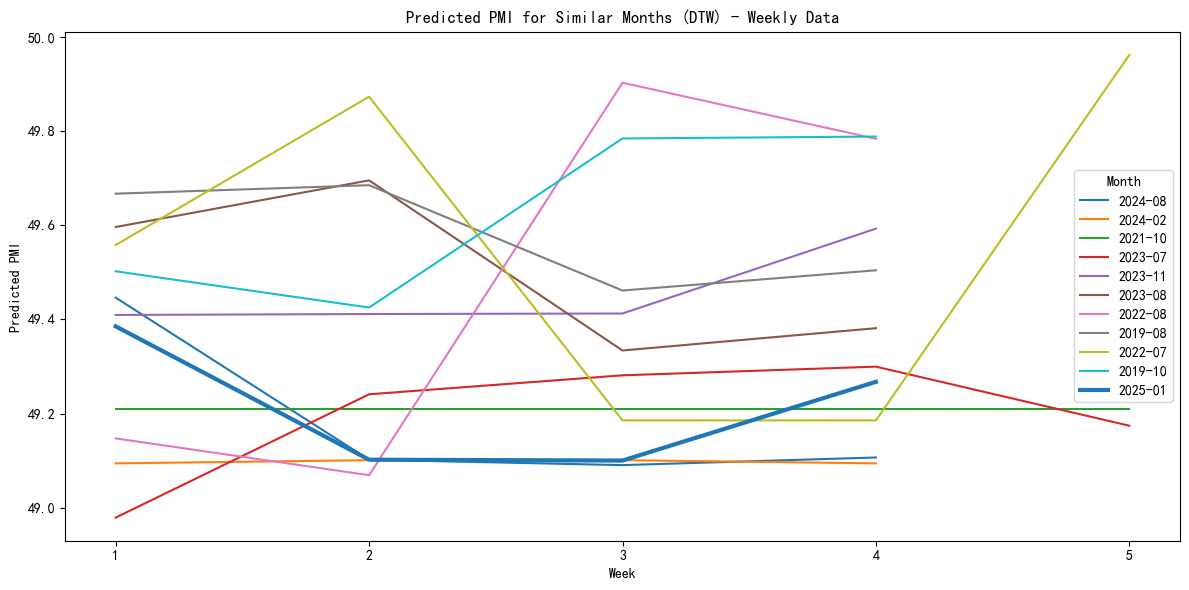

In [17]:
similar_dates = dtw_df.sort_values(by='Predicted PMI', ascending=True).head(10).index
similar_dates = similar_dates.append(pd.to_datetime(['2025-01-01']))

# 提取出年月
months = [(date.year, date.month) for date in similar_dates]

# 设置绘图
plt.figure(figsize=(12, 6))

# 遍历每个相似的年月
for year, month in months:
    # 筛选出该年月的数据
    month_data = df_pred[(df_pred['Date'].dt.year == year) & (df_pred['Date'].dt.month == month)]
    
    # 计算该月份的周次（1, 2, 3, 4, 5）
    month_data['Week'] = [i for i in range(1, len(month_data) + 1)]
    
    # 判断是否是2025年1月，并加粗
    if year == 2025 and month == 1:
        plt.plot(month_data['Week'], month_data['Predicted PMI'], label=f"{year}-{month:02d}", linewidth=3)  # 加粗线条
    else:
        plt.plot(month_data['Week'], month_data['Predicted PMI'], label=f"{year}-{month:02d}")

# 设置标题、标签和图例
plt.title('Predicted PMI for Similar Months (DTW) - Weekly Data')
plt.xlabel('Week')
plt.ylabel('Predicted PMI')
plt.legend(title="Month")
plt.xticks(range(1, 6))  # 横轴显示 1, 2, 3, 4, 5
plt.tight_layout()

# 显示图表
plt.show()

# MLP(another method)

Using the Multilayer Perceptron (MLP), we observed a reduction in the mean average error; however, the volatility of the results has increased somewhat, particularly in the month of February each year. This fluctuation may be attributed to seasonal factors, as the PMI is inherently a month-on-month data indicator.

mean average error: 0.19612276285199978


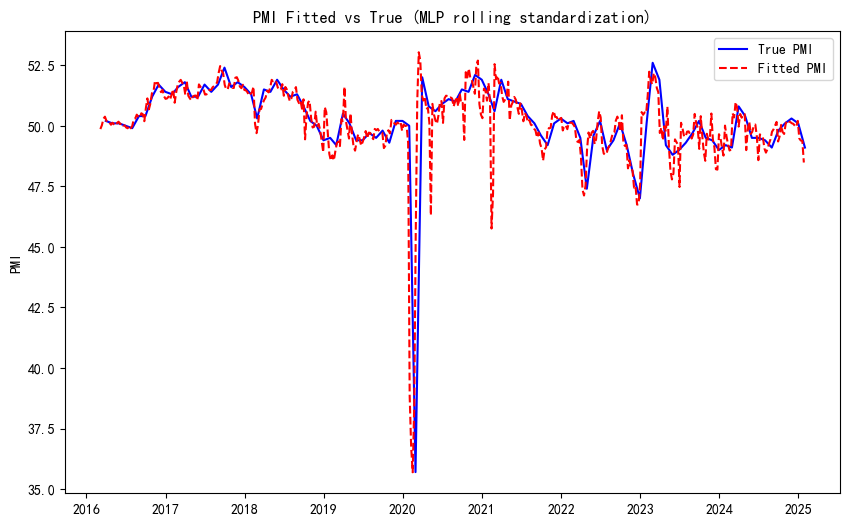

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# 字体设置微软雅黑
plt.rcParams['font.sans-serif'] = ['SimHei']

# 设置滚动训练的窗口大小（假设用过去12个月的数据进行训练）
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(df_x.shape[1])

# 存储真实PMI和预测PMI的日期
pred_dates = []
true_dates = []

# 滚动训练和预测
for i in range(window_size, len(df_y)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = df_x.iloc[i - window_size:i+1, :]  # 高频经济变量的月度数据
    y_train = df_y['中国:制造业PMI'].iloc[i - window_size:i+1]  # 月度PMI数据

    
    # 获取当前月的日期
    next_month = df_y.index[i] #测试集的月度数据
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # 筛选下一个月的周度数据
    df_weekly_filtered = df_weekly[(df_weekly.index >= next_month_start_date) & (df_weekly.index <= next_month)]
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 获取下一个月的四个周度数据作为测试集（每个周日的日期）
    X_test = df_weekly_filtered  # 使用下一个月的周度数据
    y_test = df_y['中国:制造业PMI'].iloc[i:i+1]  # 对应的月度PMI数据

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练XGBoost模型
        model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测（预测四个周度数据）
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录四个预测值
        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])

        # 获取当前月最后一个日期作为PMI的代表日期
        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # # 获取并累加当前模型的特征重要性
        # feature_importances += model.feature_importances_

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"mean average error: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(df_y) - window_size)

# 获取特征名称
feature_names = df_x.columns

# 将预测PMI和真实PMI的数据转换为DataFrame，以便绘制
df_pred = pd.DataFrame({'Date': pred_dates, 'Predicted PMI': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, 'Predicted PMI': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, 'True PMI': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, 'True PMI': true_values_2})

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['True PMI'], label='True PMI', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['Predicted PMI'], label='Fitted PMI', color='red', linestyle='--')
plt.ylabel('PMI')
plt.title('PMI Fitted vs True (MLP rolling standardization)')
plt.legend()
plt.show()



Since we have employed a rolling fitting approach, utilizing the past 12 months of data as a training set to fit the weekly data of the following month, this may result in some deviation in the forecasted outcomes. However, it ensures that no future information is used, making it more suitable for investment purposes. Our team has contemplated another approach, which involves training on data from all time periods to derive the weights of each variable for fitting. This method would allow for a more comprehensive utilization of information but would inevitably involve the use of future information during backtesting. We hope the professor can provide us with some guidance, which would be beneficial for our subsequent fitting of high-frequency GDP and CPI data.

Another issue that has arisen during this project is the concern raised by a team member that our fitted data will inevitably contain errors. They suggested using direct high-frequency data for multi-dimensional DTW calculations, arguing that this would preserve more of the original information, albeit potentially introducing some noise.

Lastly, the timing of monthly portfolio adjustments based on macroeconomic data may not have a significant impact in the A-share market. Some of the research reports we have reviewed suggest that it may not necessarily yield excess returns. Nevertheless, our current work remains highly meaningful in assessing the macroeconomic landscape and other aspects. We hope that our research can better inform our investment decisions, and we are committed to striving towards this goal.


# Fitting CPI

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 字体设置微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

df_cpi_monthly = pd.read_excel(r'C:\QPS\CPI.xlsx',skiprows=1,sheet_name='Sheet5')
df_cpi_monthly['Date'] = pd.to_datetime(df_cpi_monthly['指标名称'], errors='coerce')
# Set the Date column as the index
df_cpi_monthly.set_index('Date', inplace=True)
df_cpi_monthly = df_cpi_monthly.drop(columns=['指标名称'])
df_cpi_monthly = df_cpi_monthly.resample('M').mean()

In [94]:
df_cpi_monthly_mom = df_cpi_monthly.pct_change(1)*100 # Calculate the month-on-month growth rate

In [95]:
df_cpi = pd.read_excel(r'C:\QPS\CPI.xlsx',skiprows=1,sheet_name='Sheet6')
df_cpi['Date'] = pd.to_datetime(df_cpi['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_cpi.set_index('Date', inplace=True)
df_cpi = df_cpi.drop(columns=['指标名称']) # Monthly CPI data

In [ ]:
# Seasonal adjustment for non-food CPI
df_cpi["中国:核心CPI:环比季节性"] = df_cpi.index.map(
    lambda date: df_cpi[
        (df_cpi.index.month == date.month) & 
        (df_cpi.index.year < date.year) & 
        (df_cpi.index.year >= date.year - 5)
    ]["中国:CPI:不包括食品和能源(核心CPI):环比"].mean())

df_cpi["中国:非食品CPI:环比季节性"] = df_cpi.index.map(
    lambda date: df_cpi[
        (df_cpi.index.month == date.month) & 
        (df_cpi.index.year < date.year) & 
        (df_cpi.index.year >= date.year - 5)
    ]["中国:CPI:非食品:环比"].mean()) # Seasonal adjustment for non-food CPI

In [98]:
df_cpi_food_x = df_cpi_monthly_mom.iloc[1:-1,:-2]
df_cpi_energy_x = df_cpi_monthly_mom.iloc[1:-1,-2:]
df_cpi_y = df_cpi[(df_cpi.index>='2014-01-01') & (df_cpi.index <= '2025-02-28')]

We can see from the plot that the volatility of the CPI (green line) is mostly explained by food CPI (blue line).

<Axes: xlabel='Date'>

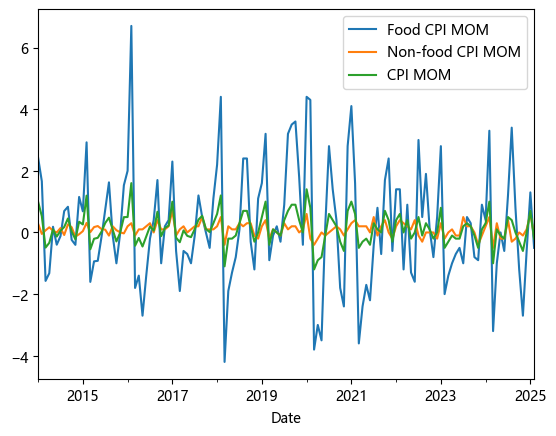

In [99]:
df_cpi_plot = df_cpi_y[['中国:CPI:食品:环比','中国:CPI:非食品:环比','中国:CPI:环比']].copy()
df_cpi_plot = df_cpi_plot.rename(columns={'中国:CPI:食品:环比':'Food CPI MOM','中国:CPI:非食品:环比':'Non-food CPI MOM','中国:CPI:环比':'CPI MOM'})
df_cpi_plot.plot()

Since CPI is calculated by linear methods, we use linear regression to fit it.

In [100]:
display(df_cpi_food_x)
display(df_cpi_y)

,平均批发价:猪肉,平均价:牛肉:全国,平均价:羊肉:全国,平均批发价:28种重点监测蔬菜,平均批发价:7种重点监测水果,平均批发价:鸡蛋,零售价:粮食:小包装大米,市场价:小麦:国标三等:全国,零售价:桶装食用油:花生油,零售价:桶装食用油:菜籽油,零售价:桶装食用油:调和油,中国:批发价:草鱼,中国:批发价:鲢鱼,批发价:鲤鱼,批发价:鲫鱼,批发价:大带鱼
Date,,,,,,,,,,,,,,,,
2014-01-31,-4.482816,1.983953,2.243902,11.165399,12.508632,1.420396,0.240590,-0.533615,-0.281745,-0.536166,-0.212766,0.300619,0.894220,1.563677,-2.368054,2.382528
2014-02-28,-7.137309,0.818068,0.530027,10.122718,5.303447,-5.171140,0.185816,0.221674,0.029228,-0.139002,-0.017768,-0.246827,2.977735,0.902826,-0.332911,-1.066580
2014-03-31,-7.126695,-1.665567,-1.787105,-4.684573,-3.551236,0.639349,-0.038640,0.002618,-0.116879,-0.271601,-0.177715,-0.830682,-1.049593,-0.259347,-0.954350,-1.543613
2014-04-30,-8.788831,-1.149716,-1.553098,-12.085944,7.008761,6.790160,0.193274,-1.940871,-0.224281,-0.340426,-0.462881,-0.124755,-0.371254,-1.040087,-0.224827,-1.708835
2014-05-31,7.832981,-0.035148,-0.512317,-9.559572,8.242174,14.959673,-0.185185,0.197528,-0.250195,-0.502135,-0.425684,3.026410,1.250998,5.907598,2.095606,0.437168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,-6.988030,-0.987283,-0.415304,-6.599628,-0.628708,-3.780415,-0.264951,0.168734,0.285640,-0.035600,-0.158422,-0.514534,-1.177302,-1.139958,-0.271143,-0.147062
2024-11-30,-3.735648,-0.923842,-0.132823,-12.487147,-1.284377,-1.679424,-0.447818,-0.106822,-0.086311,-0.088636,-0.349081,-0.967209,-1.696450,-1.666264,-2.475401,-0.232927
2024-12-31,-4.186381,-0.825613,-0.010726,-0.561094,0.304723,-0.323889,-0.198231,-1.604036,-0.362820,-0.346936,-0.260930,-0.299350,-0.128460,-0.288556,-0.846963,0.029070


,中国:CPI:食品:环比,中国:CPI:非食品:环比,中国:CPI:环比,中国:CPI:不包括食品和能源(核心CPI):环比,中国:CPI:交通和通信:环比,中国:CPI:当月同比,中国:核心CPI:环比季节性,中国:非食品CPI:环比季节性
Date,,,,,,,,
2014-01-31,2.4263,0.2848,0.9979,0.3,0.4040,2.4861,0.10,0.06706
2014-02-28,1.6598,-0.0477,0.5288,0.0,-0.0666,1.9511,0.30,0.00946
2014-03-31,-1.5719,0.0685,-0.4917,0.1,-0.2787,2.3848,0.10,0.02296
2014-04-30,-1.3219,0.1667,-0.3361,0.2,-0.0022,1.8014,0.20,0.25048
2014-05-31,0.1848,0.0582,0.1006,0.1,0.1417,2.4773,0.00,0.02814
...,...,...,...,...,...,...,...,...
2024-10-31,-1.2000,0.0000,-0.3000,0.0,-0.7000,0.3000,0.08,0.14000
2024-11-30,-2.7000,-0.1000,-0.6000,-0.1,-0.1000,0.2000,-0.18,-0.10000
2024-12-31,-0.6000,0.1000,0.0000,0.2,0.3000,0.1000,0.04,-0.06000


MAE: 0.7074329039300519


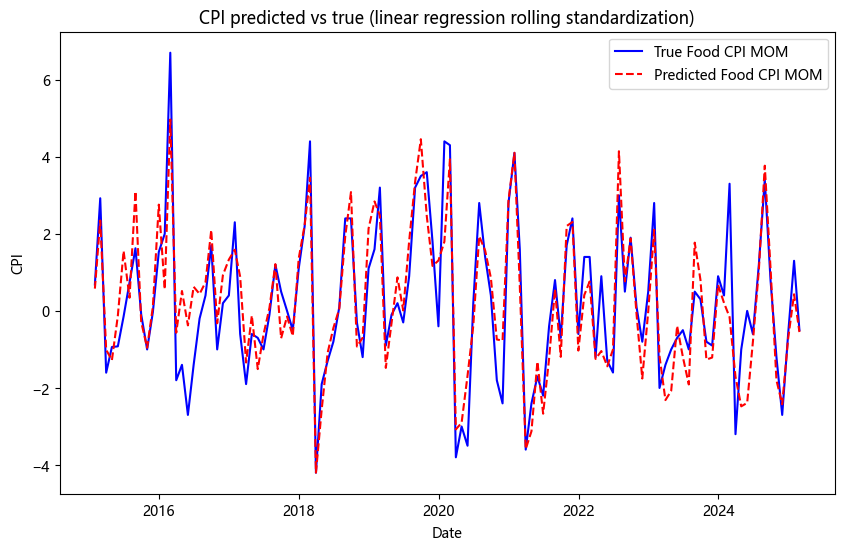

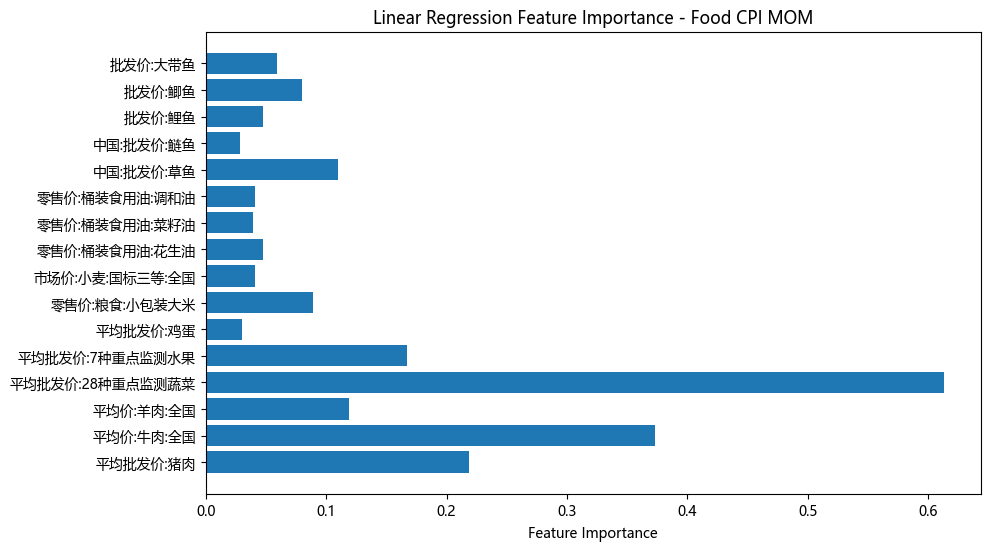

In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 字体设置为微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 设置滚动训练的窗口大小（假设用过去12个月的数据进行训练）
window_size = 12
predictions = []
true_values = []
feature_importances = np.zeros(df_cpi_food_x.shape[1])  # 线性回归没有 feature_importances_，我们用系数代替

# 滚动训练和预测
for i in range(window_size, len(df_cpi_food_x)):
    # 训练集：从最初到当前 i 的所有数据
    # X_train = df_cpi_food_x.iloc[i - window_size:i, :]
    # y_train = df_cpi_y['中国:CPI:食品:环比'].iloc[i - window_size:i]


    X_train = df_cpi_food_x.iloc[0:i, :]
    y_train = df_cpi_y['中国:CPI:食品:环比'].iloc[0:i]   
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 测试集：当前时刻的目标值
    X_test = df_cpi_food_x.iloc[i:i+1, :]
    y_test = df_cpi_y['中国:CPI:食品:环比'].iloc[i:i+1]

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练 线性回归 模型
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录预测结果
        predictions.append(y_pred_rescaled[0][0])
        true_values.append(y_test_rescaled[0][0])

        # 线性回归的特征重要性可以用系数（coef_）表示
        feature_importances += np.abs(model.coef_)

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values, predictions)
print(f"MAE: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(df_cpi_y) - window_size)

# 获取特征名称
feature_names = df_cpi_food_x.columns

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(df_cpi_y.index[window_size:], true_values, label='True Food CPI MOM', color='blue')
plt.plot(df_cpi_y.index[window_size:], predictions, label='Predicted Food CPI MOM', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI predicted vs true (linear regression rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Linear Regression Feature Importance - Food CPI MOM')
plt.show()


In [102]:
df_result = pd.concat([pd.Series(true_values, index=df_cpi_y.index[window_size:]), pd.Series(predictions, index=df_cpi_y.index[window_size:])], axis=1, keys=['真实食品CPI', '预测食品CPI'])
df_result = pd.merge(df_result,df_cpi_y,left_on='Date',right_on='Date',how='left') #merge with the original data

In [103]:
df_result.head()

,真实食品CPI,预测食品CPI,中国:CPI:食品:环比,中国:CPI:非食品:环比,中国:CPI:环比,中国:CPI:不包括食品和能源(核心CPI):环比,中国:CPI:交通和通信:环比,中国:CPI:当月同比,中国:核心CPI:环比季节性,中国:非食品CPI:环比季节性
Date,,,,,,,,,,
2015-01-31,0.6865,0.577928,0.6865,0.0426,0.2598,0.2000,-0.4379,0.7638,0.20,0.18402
2015-02-28,2.9231,2.345966,2.9231,0.3088,1.1946,0.3668,0.4723,1.4311,0.15,0.07992
2015-03-31,-1.6034,-1.009420,-1.6034,0.0100,-0.5460,-0.0575,-0.1154,1.3758,0.10,0.05666
2015-04-30,-0.9376,-1.278997,-0.9376,0.1740,-0.2050,0.2127,-0.0165,1.5091,0.20,0.26382
2015-05-31,-0.9201,-0.124411,-0.9201,0.2079,-0.1739,0.1657,0.3602,1.2308,0.05,0.05978


## Linear regression again

In [104]:
cpi_x = df_result[['预测食品CPI','中国:非食品CPI:环比季节性']]
cpi_y = df_result[['中国:CPI:环比']] # Monthly CPI data

In [105]:
display(cpi_x)
display(cpi_y)

,预测食品CPI,中国:非食品CPI:环比季节性
Date,,
2015-01-31,0.577928,0.18402
2015-02-28,2.345966,0.07992
2015-03-31,-1.009420,0.05666
2015-04-30,-1.278997,0.26382
2015-05-31,-0.124411,0.05978
...,...,...
2024-10-31,-1.799866,0.14000
2024-11-30,-2.422608,-0.10000
2024-12-31,-0.721115,-0.06000


,中国:CPI:环比
Date,
2015-01-31,0.2598
2015-02-28,1.1946
2015-03-31,-0.5460
2015-04-30,-0.2050
2015-05-31,-0.1739
...,...
2024-10-31,-0.3000
2024-11-30,-0.6000
2024-12-31,0.0000


MAE: 0.24120825240694307


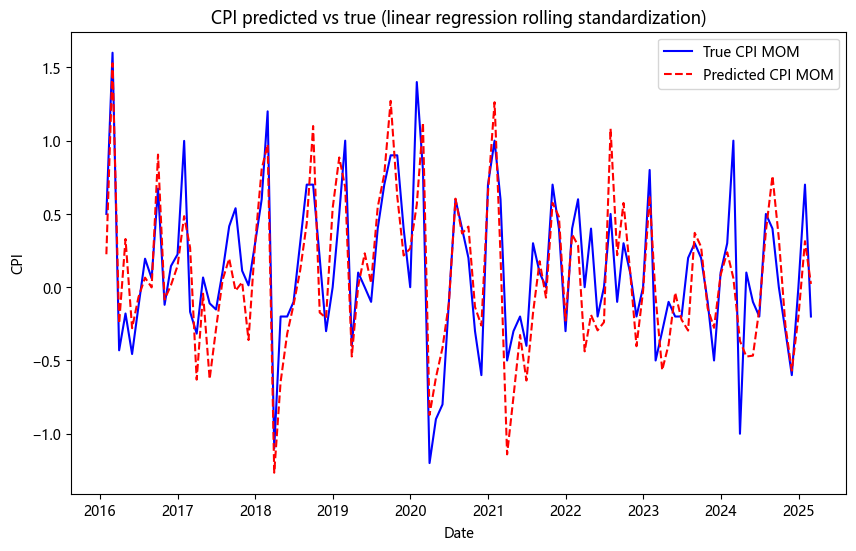

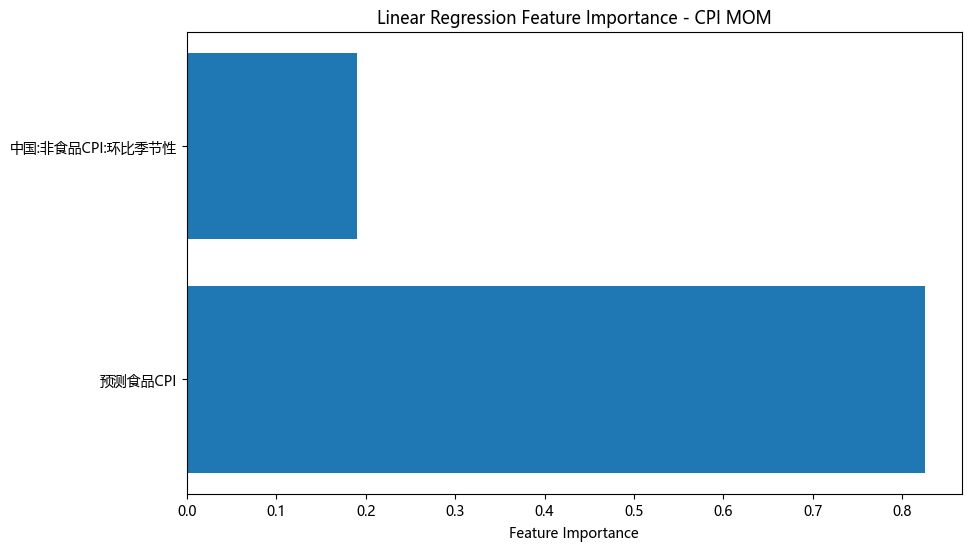

In [106]:
# 线性回归
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# set the font to Microsoft YaHei
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# set the rolling window size (use the past 12 months of data for training)
window_size = 12
predictions = []
true_values = []
feature_importances = np.zeros(cpi_x.shape[1])  # Linear regression does not have feature_importances_, we use coefficients instead


for i in range(window_size, len(cpi_x)):
    # 训练集：从最初到当前 i 的所有数据
    X_train = cpi_x.iloc[0:i, :]
    y_train = cpi_y.iloc[0:i]   
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 测试集：当前时刻的目标值
    X_test = cpi_x.iloc[i:i+1, :]
    y_test = cpi_y.iloc[i:i+1]

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练 线性回归 模型
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录预测结果
        predictions.append(y_pred_rescaled[0][0])
        true_values.append(y_test_rescaled[0][0])

        # 线性回归的特征重要性可以用系数（coef_）表示
        feature_importances += np.abs(model.coef_)

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values, predictions)
print(f"MAE: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(cpi_y) - window_size)

# 获取特征名称
feature_names = cpi_x.columns

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(cpi_y.index[window_size:], true_values, label='True CPI MOM', color='blue')
plt.plot(cpi_y.index[window_size:], predictions, label='Predicted CPI MOM', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI predicted vs true (linear regression rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Linear Regression Feature Importance - CPI MOM')
plt.show()


# Fiiting CPI yoy using CPI mom data

In [107]:
df_true_CPI = pd.concat([pd.Series(true_values, index=cpi_y.index[window_size:]), pd.Series(predictions, index=cpi_y.index[window_size:])], axis=1, keys=['中国:CPI:环比', '中国:CPI:环比:月度预测'])
df_cpi = df_result['中国:CPI:环比'].reset_index()
df_true_CPI = df_cpi.merge(df_true_CPI,left_on='Date',right_on='Date',how='left').rename(columns={'中国:CPI:环比_x':'中国:CPI:环比'})
df_true_CPI.drop(columns=['中国:CPI:环比_y'],inplace=True)
df_true_CPI

,Date,中国:CPI:环比,中国:CPI:环比:月度预测
0,2015-01-31,0.2598,NaN
1,2015-02-28,1.1946,NaN
2,2015-03-31,-0.5460,NaN
3,2015-04-30,-0.2050,NaN
4,2015-05-31,-0.1739,NaN
...,...,...,...
117,2024-10-31,-0.3000,-0.261714
118,2024-11-30,-0.6000,-0.568652
119,2024-12-31,0.0000,-0.202527
120,2025-01-31,0.7000,0.313889


In [108]:
df_merge = df_true_CPI.copy()
df_merge.set_index('Date',inplace=True) # Set the date column as the index
df_merge["中国:CPI:当月同比"] = df_result["中国:CPI:当月同比"] # Add the year-on-year CPI data
df_merge

,中国:CPI:环比,中国:CPI:环比:月度预测,中国:CPI:当月同比
Date,,,
2015-01-31,0.2598,NaN,0.7638
2015-02-28,1.1946,NaN,1.4311
2015-03-31,-0.5460,NaN,1.3758
2015-04-30,-0.2050,NaN,1.5091
2015-05-31,-0.1739,NaN,1.2308
...,...,...,...
2024-10-31,-0.3000,-0.261714,0.3000
2024-11-30,-0.6000,-0.568652,0.2000
2024-12-31,0.0000,-0.202527,0.1000


In [109]:
df_merge["中国:CPI:同比:当月预测"] = (
    (1 + (df_merge["中国:CPI:当月同比"].shift(1))/100) *  # Use the previous month's year-on-year CPI data
    (1 + (df_merge["中国:CPI:环比:月度预测"])/100) /  # Use the predicted month-on-month CPI growth rate
    (1 + (df_merge["中国:CPI:环比"].shift(12)/100))  # Use the year-ago month-on-month CPI growth rate
)*100 - 100

The yellow line presents the prediction, the blue line presents the actual yoy data.

Mean average error: 0.25335087320999594


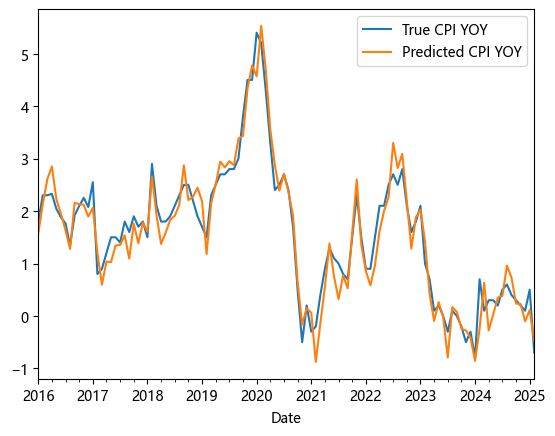

In [110]:
df_merge.dropna(inplace = True)
df_cpi_YOY = df_merge[['中国:CPI:当月同比','中国:CPI:同比:当月预测']].copy()
df_cpi_YOY = df_cpi_YOY.rename(columns={'中国:CPI:当月同比':'True CPI YOY','中国:CPI:同比:当月预测':'Predicted CPI YOY'})
df_cpi_YOY.plot() # Plot the year-on-year CPI data and the predicted year-on-year CPI data
mae = mean_absolute_error(df_merge['中国:CPI:当月同比'], df_merge['中国:CPI:同比:当月预测'])
print(f"Mean average error: {mae}")

# Fitting the weekly data.

In [144]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# 字体设置为微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
df_cpi_weekly = pd.read_excel(r'C:\QPS\CPI.xlsx',skiprows=1,sheet_name='Sheet5')
df_cpi_weekly['Date'] = pd.to_datetime(df_cpi_weekly['指标名称'], errors='coerce')
# Set the Date column as the index
df_cpi_weekly.set_index('Date', inplace=True)
df_cpi_weekly = df_cpi_weekly.drop(columns=['指标名称'])
df_cpi_weekly = df_cpi_weekly.fillna(method='ffill')
df_cpi_weekly = df_cpi_weekly.resample('W').mean() # resample to weekly data

In [145]:
df_cpi_weekly = df_cpi_weekly.pct_change(1)*100
df_cpi_weekly = df_cpi_weekly.dropna() # Calculate the week-on-week growth rate
df_cpi_food_x_weekly = df_cpi_weekly[(df_cpi_weekly.index>='2014-02-01') & (df_cpi_weekly.index<='2025-02-28')].iloc[:,:-2] # from 2014.02

In [146]:
display(df_cpi_food_x_weekly)
display(df_cpi_y)

,平均批发价:猪肉,平均价:牛肉:全国,平均价:羊肉:全国,平均批发价:28种重点监测蔬菜,平均批发价:7种重点监测水果,平均批发价:鸡蛋,零售价:粮食:小包装大米,市场价:小麦:国标三等:全国,零售价:桶装食用油:花生油,零售价:桶装食用油:菜籽油,零售价:桶装食用油:调和油,中国:批发价:草鱼,中国:批发价:鲢鱼,批发价:鲤鱼,批发价:鲫鱼,批发价:大带鱼
Date,,,,,,,,,,,,,,,,
2014-02-02,-1.108830,0.985607,0.903450,7.667732,3.546823,-0.615446,0.051600,-0.052493,-0.025988,-0.248644,-0.118427,1.272385,1.888163,0.843759,0.808683,0.439207
2014-02-09,-0.930233,0.495740,0.182024,0.816024,3.942829,-0.579305,0.257865,-0.105042,0.168963,0.000000,0.023714,0.093067,2.423378,0.750144,-0.759975,-1.642491
2014-02-16,-0.160966,-0.286727,-0.176783,-0.706402,-2.133713,-2.157926,-0.030864,0.000000,-0.007785,0.027192,0.028450,-0.237099,-0.187891,-0.017182,0.038290,0.097593
2014-02-23,-2.740830,-0.534908,-0.507674,-1.289462,-4.825581,-2.143913,-0.123495,0.126183,-0.038929,0.122332,0.085324,-1.104432,-0.690232,-0.240591,0.178617,0.162496
2014-03-02,-2.559055,-0.453853,-0.554764,-0.450450,-0.335980,-1.057668,-0.030912,0.320573,-0.062310,0.040728,-0.099460,-0.692677,0.252738,-0.792420,0.178299,-1.083712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-26,0.782190,-0.229952,0.273193,3.571429,1.998335,-1.627707,0.000000,-0.012730,-0.003093,0.089394,0.006898,0.327973,0.606909,0.431770,-0.189442,0.598280
2025-02-02,2.002184,0.465542,0.877256,6.616962,1.904762,0.083907,0.076336,0.000000,-0.015466,-0.111643,-0.079327,1.288882,1.720138,1.941152,1.456544,1.920644
2025-02-09,-1.627409,-0.227894,-0.137868,-5.419580,-0.267023,-7.671026,0.152555,0.000000,0.000000,-0.015967,-0.010355,-0.554489,0.117980,0.841852,-0.230885,-0.212832


,中国:CPI:食品:环比,中国:CPI:非食品:环比,中国:CPI:环比,中国:CPI:不包括食品和能源(核心CPI):环比,中国:CPI:交通和通信:环比,中国:CPI:当月同比,中国:核心CPI:环比季节性,中国:非食品CPI:环比季节性
Date,,,,,,,,
2014-01-31,2.4263,0.2848,0.9979,0.3,0.4040,2.4861,0.10,0.06706
2014-02-28,1.6598,-0.0477,0.5288,0.0,-0.0666,1.9511,0.30,0.00946
2014-03-31,-1.5719,0.0685,-0.4917,0.1,-0.2787,2.3848,0.10,0.02296
2014-04-30,-1.3219,0.1667,-0.3361,0.2,-0.0022,1.8014,0.20,0.25048
2014-05-31,0.1848,0.0582,0.1006,0.1,0.1417,2.4773,0.00,0.02814
...,...,...,...,...,...,...,...,...
2024-10-31,-1.2000,0.0000,-0.3000,0.0,-0.7000,0.3000,0.08,0.14000
2024-11-30,-2.7000,-0.1000,-0.6000,-0.1,-0.1000,0.2000,-0.18,-0.10000
2024-12-31,-0.6000,0.1000,0.0000,0.2,0.3000,0.1000,0.04,-0.06000


MAE: 1.2410477239790347


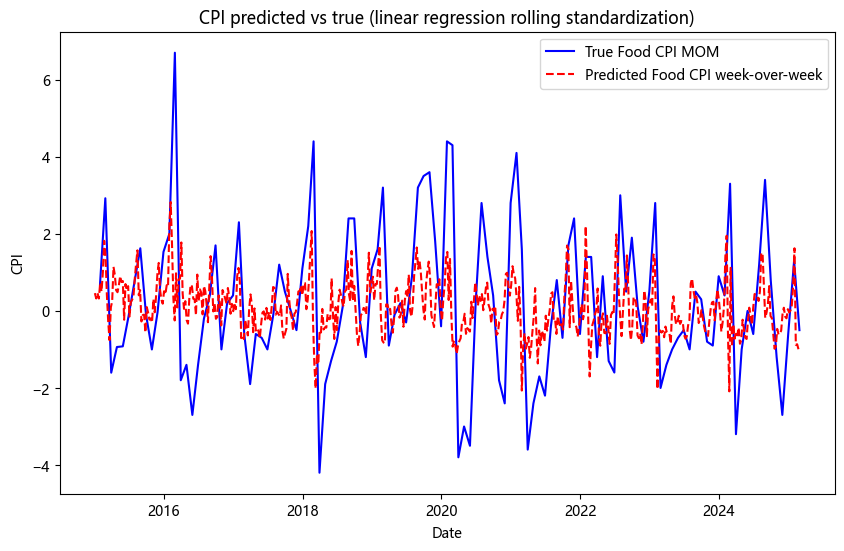

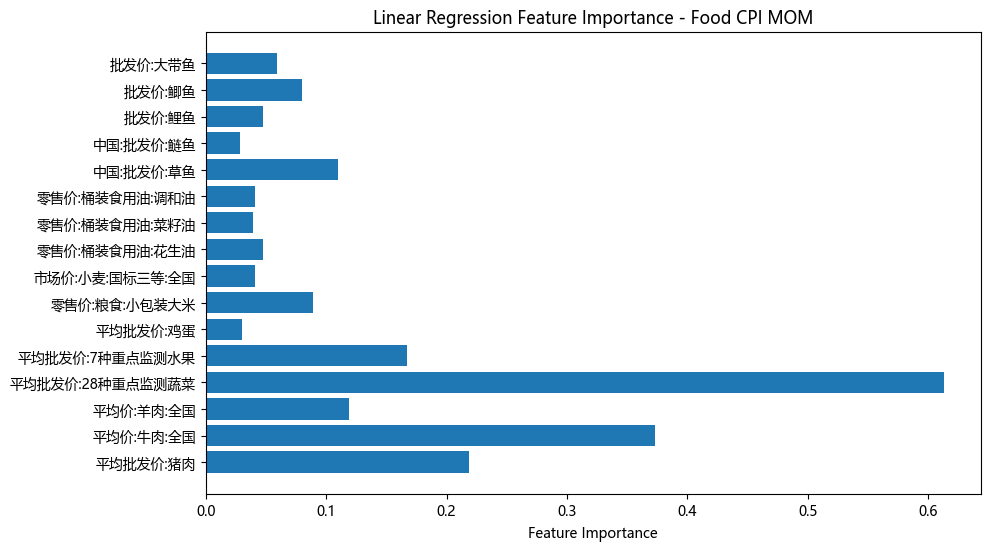

In [147]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


# 设置滚动训练的窗口大小（假设用过去12个月的数据进行训练）
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(df_cpi_food_x.shape[1])

# 存储真实PMI和预测PMI的日期
pred_dates = []
true_dates = []

# 滚动训练和预测
for i in range(window_size, len(df_cpi_y)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = df_cpi_food_x.iloc[0:i, :]
    y_train = df_cpi_y['中国:CPI:食品:环比'].iloc[0:i] 
  
    
    # 获取当前月的日期
    next_month = df_cpi_y.index[i] #测试集的月度数据
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # 筛选下一个月的周度数据
    df_weekly_filtered = df_cpi_food_x_weekly[(df_cpi_food_x_weekly.index >= next_month_start_date) & (df_cpi_food_x_weekly.index <= next_month)]
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 获取下一个月的四个周度数据作为测试集（每个周日的日期）
    X_test = df_weekly_filtered  # 使用下一个月的周度数据
    y_test = df_cpi_y['中国:CPI:食品:环比'].iloc[i:i+1]  # 对应的月度PMI数据

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练XGBoost模型
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测（预测四个周度数据）
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录四个预测值
        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])

        # 获取当前月最后一个日期作为PMI的代表日期
        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # 获取并累加当前模型的特征重要性
        feature_importances += np.abs(model.coef_)

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"MAE: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(df_cpi_y) - window_size)

# 获取特征名称
feature_names = df_cpi_food_x.columns

# 将预测PMI和真实PMI的数据转换为DataFrame，以便绘制
df_pred = pd.DataFrame({'Date': pred_dates, '预测食品CPI': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, '预测食品CPI': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, 'True CPI': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, 'True CPI': true_values_2})

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['True CPI'], label='True Food CPI MOM', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['预测食品CPI'], label='Predicted Food CPI week-over-week', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI predicted vs true (linear regression rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Linear Regression Feature Importance - Food CPI MOM')
plt.show()


# Linear regression again

In [148]:
df_pred # Predicted food CPI data

,Date,预测食品CPI
0,2015-01-04,0.460270
1,2015-01-11,0.322057
2,2015-01-18,0.459995
3,2015-01-25,0.321473
4,2015-02-01,0.731926
...,...,...
525,2025-01-26,0.657045
526,2025-02-02,1.624951
527,2025-02-09,-0.881128
528,2025-02-16,-0.865380


In [149]:
df_cpi = pd.read_excel(r'C:\QPS\CPI.xlsx',skiprows=1,sheet_name='Sheet6')
df_cpi['Date'] = pd.to_datetime(df_cpi['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_cpi.set_index('Date', inplace=True)
df_cpi = df_cpi.drop(columns=['指标名称'])

In [150]:
df_seasonality = df_cpi['中国:CPI:非食品:环比'].resample('W').fillna(method='bfill').reset_index() # Seasonal adjustment for non-food CPI
df_seasonality['中国:非食品CPI:环比季节性'] = (
    df_seasonality['中国:CPI:非食品:环比'].shift(52) + 
    df_seasonality['中国:CPI:非食品:环比'].shift(52*2) +
    df_seasonality['中国:CPI:非食品:环比'].shift(52*3) +
    df_seasonality['中国:CPI:非食品:环比'].shift(52*4) +
    df_seasonality['中国:CPI:非食品:环比'].shift(52*5)
)/5

In [151]:
df_pred["Date"] = pd.to_datetime(df_pred["Date"])
df_result.index = pd.to_datetime(df_result.index)

df_pred_weekly = df_pred.merge(
    df_seasonality,
    left_on=df_pred["Date"],
    right_on="Date",
    how="left"
).drop(columns=["Date_y"])
df_pred_weekly = df_pred_weekly[['Date','预测食品CPI','中国:非食品CPI:环比季节性']].set_index('Date')
df_pred_weekly

,预测食品CPI,中国:非食品CPI:环比季节性
Date,,
2015-01-04,0.460270,0.18402
2015-01-11,0.322057,0.18402
2015-01-18,0.459995,0.18402
2015-01-25,0.321473,0.18402
2015-02-01,0.731926,0.07992
...,...,...
2025-01-26,0.657045,0.16000
2025-02-02,1.624951,0.18000
2025-02-09,-0.881128,0.18000


In [152]:
cpi_x = df_result[['预测食品CPI','中国:非食品CPI:环比季节性']]
cpi_y = df_result[['中国:CPI:环比']]
display(cpi_x)
display(cpi_y)

,预测食品CPI,中国:非食品CPI:环比季节性
Date,,
2015-01-31,0.577928,0.18402
2015-02-28,2.345966,0.07992
2015-03-31,-1.009420,0.05666
2015-04-30,-1.278997,0.26382
2015-05-31,-0.124411,0.05978
...,...,...
2024-10-31,-1.799866,0.14000
2024-11-30,-2.422608,-0.10000
2024-12-31,-0.721115,-0.06000


,中国:CPI:环比
Date,
2015-01-31,0.2598
2015-02-28,1.1946
2015-03-31,-0.5460
2015-04-30,-0.2050
2015-05-31,-0.1739
...,...
2024-10-31,-0.3000
2024-11-30,-0.6000
2024-12-31,0.0000


平均绝对误差（MAE）: 0.3075053071245557


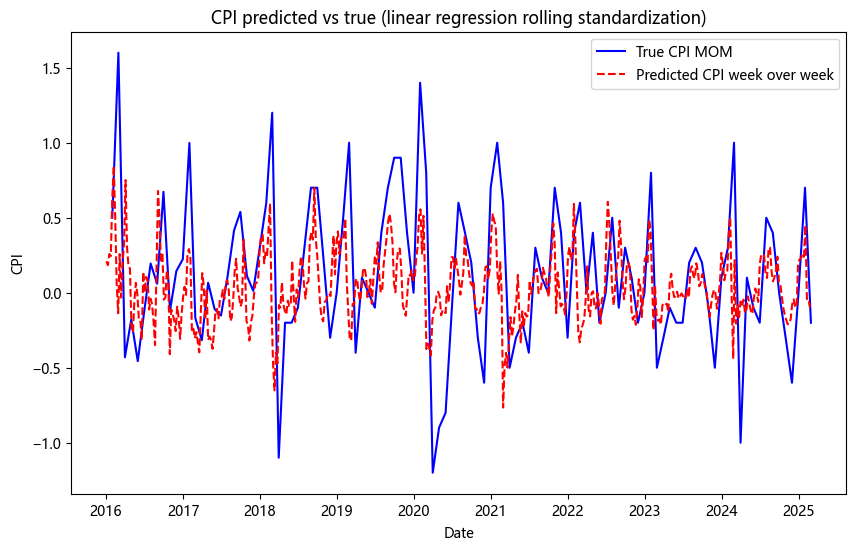

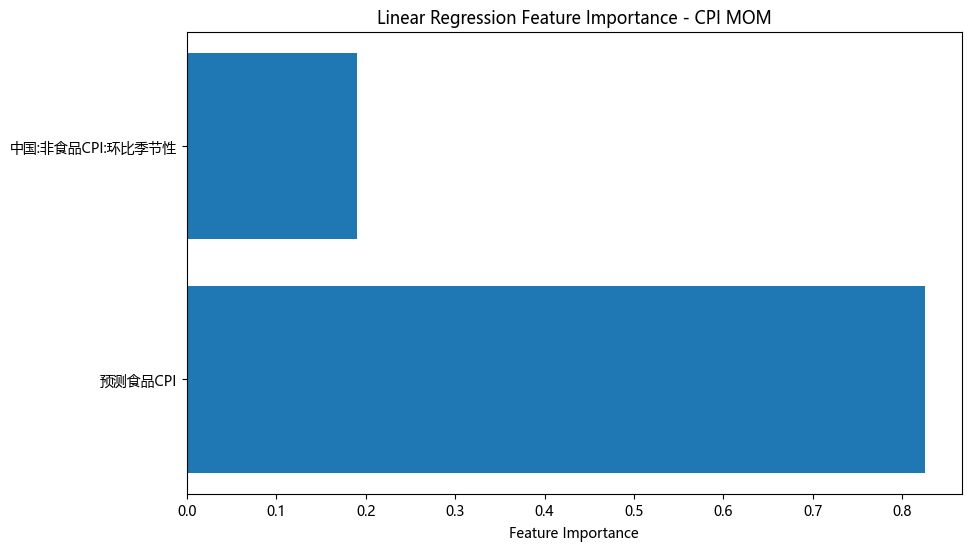

In [153]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


# 设置滚动训练的窗口大小（假设用过去12个月的数据进行训练）
window_size = 12
predictions = []
predictions_mean=[]
true_values = []
true_values_2 = []
true_dates_2 = []
feature_importances = np.zeros(cpi_x.shape[1])

# 存储真实PMI和预测PMI的日期
pred_dates = []
true_dates = []

# 滚动训练和预测
for i in range(window_size, len(cpi_x)):
    # 获取当前窗口的训练数据（过去12个月）
    X_train = cpi_x.iloc[0:i, :]
    y_train = cpi_y.iloc[0:i] 
  
    
    # 获取当前月的日期
    next_month = cpi_y.index[i] #测试集的月度数据
    next_month_year = next_month.year
    next_month_num = next_month.month
    next_month_start_date = pd.Timestamp(f"{next_month_year}-{next_month_num:02d}-01")
    
    # 筛选下一个月的周度数据
    df_weekly_filtered = df_pred_weekly[(df_pred_weekly.index >= next_month_start_date) & (df_pred_weekly.index <= next_month)]
    
    # 初始化并训练标准化器
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 仅使用当前窗口数据对训练集进行标准化
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

    # 获取下一个月的四个周度数据作为测试集（每个周日的日期）
    X_test = df_weekly_filtered  # 使用下一个月的周度数据
    y_test = cpi_y.iloc[i:i+1]  # 对应的月度PMI数据

    # 对测试集进行标准化（使用训练集的scaler）
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 确保训练集和测试集不为空
    if X_train_scaled.shape[0] > 0 and X_test_scaled.shape[0] > 0:
        # 初始化并训练XGBoost模型
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled.ravel())
        
        # 进行预测（预测四个周度数据）
        y_pred_scaled = model.predict(X_test_scaled)
        
        # 反标准化预测值和真实值
        y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
        
        # 记录四个预测值
        predictions.extend(y_pred_rescaled.flatten())
        predictions_mean.extend([np.mean(y_pred_rescaled)])
        true_values.extend([y_test_rescaled[0][0]]*len(y_pred_rescaled))  # 填充真实PMI的每周数据
        true_values_2.extend([y_test_rescaled[0][0]])

        # 获取当前月最后一个日期作为PMI的代表日期
        pred_dates.extend(df_weekly_filtered.index)  # 用周度数据的日期
        true_dates.extend([next_month] * len(df_weekly_filtered))  # 用月度数据的日期填充真实数据
        true_dates_2.extend([next_month])

        # 获取并累加当前模型的特征重要性
        feature_importances += np.abs(model.coef_)

# 计算并输出平均绝对误差
mae = mean_absolute_error(true_values_2, predictions_mean)
print(f"平均绝对误差（MAE）: {mae}")

# 计算特征重要性的平均值
feature_importances /= (len(cpi_y) - window_size)

# 获取特征名称
feature_names = cpi_x.columns

# 将预测PMI和真实PMI的数据转换为DataFrame，以便绘制
df_pred = pd.DataFrame({'Date': pred_dates, '中国:CPI:预测环比': predictions})
df_pred_mean = pd.DataFrame({'Date': true_dates_2, '中国:CPI:预测环比': predictions_mean})
df_true = pd.DataFrame({'Date': true_dates, '中国:CPI:环比': true_values})
df_true_2 = pd.DataFrame({'Date': true_dates_2, '中国:CPI:环比': true_values_2})

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(df_true['Date'], df_true['中国:CPI:环比'], label='True CPI MOM', color='blue', linestyle='-')
plt.plot(df_pred['Date'], df_pred['中国:CPI:预测环比'], label='Predicted CPI week over week', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('CPI predicted vs true (linear regression rolling standardization)')
plt.legend()
plt.show()

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Linear Regression Feature Importance - CPI MOM')
plt.show()


In [154]:
df_true_3 = pd.DataFrame({'Date': pred_dates, '中国:CPI:环比': true_values})

df_merged_weekly = pd.merge(df_pred, df_true_3, on=["Date"], how="left")
df_merged_weekly

,Date,中国:CPI:预测环比,中国:CPI:环比
0,2016-01-03,0.208986,0.5
1,2016-01-10,0.183553,0.5
2,2016-01-17,0.257965,0.5
3,2016-01-24,0.244455,0.5
4,2016-01-31,0.629940,0.5
...,...,...,...
473,2025-01-26,0.239528,0.7
474,2025-02-02,0.450886,-0.2
475,2025-02-09,-0.043005,-0.2
476,2025-02-16,-0.039901,-0.2


In [155]:
# 确保日期列格式正确
df_merged_weekly["Date"] = pd.to_datetime(df_merged_weekly["Date"])
df_result.index = pd.to_datetime(df_result.index)

# 通过月份匹配，将月度数据复制到周度数据
df_merged_weekly = df_merged_weekly.merge(
    df_result['中国:CPI:当月同比'].reset_index().rename(columns={"Date": "Month"})
        .assign(Month=lambda x: x["Month"].dt.to_period("M")),
    left_on=df_merged_weekly["Date"].dt.to_period("M"),
    right_on="Month",
    how="left"
).drop(columns=["Month"])

df_cpi = pd.read_excel(r'C:\QPS\CPI.xlsx',skiprows=1,sheet_name='Sheet6')
df_cpi['Date'] = pd.to_datetime(df_cpi['指标名称'], errors='coerce')
# Set the '日期' column as the index
df_cpi.set_index('Date', inplace=True)
df_cpi = df_cpi.drop(columns=['指标名称'])

df_cpi = df_cpi[['中国:CPI:环比','中国:CPI:当月同比']]
df_cpi = df_cpi[df_cpi.index>'2010-01-01']

df_cpi_week = df_cpi.resample('w').fillna(method='bfill').dropna()
df_cpi_week = df_cpi_week.reset_index()
df_cpi_week

,Date,中国:CPI:环比,中国:CPI:当月同比
0,2010-01-31,0.6,1.5
1,2010-02-07,1.2,2.7
2,2010-02-14,1.2,2.7
3,2010-02-21,1.2,2.7
4,2010-02-28,1.2,2.7
...,...,...,...
782,2025-01-26,0.7,0.5
783,2025-02-02,-0.2,-0.7
784,2025-02-09,-0.2,-0.7
785,2025-02-16,-0.2,-0.7


In [157]:
df_merged_weekly = df_cpi_week.merge(df_merged_weekly, left_on="Date", right_on="Date", how="left")
df_merged_weekly = df_merged_weekly.drop(columns=['中国:CPI:环比_y', '中国:CPI:当月同比_y']).rename(columns={'中国:CPI:环比_x':'中国:CPI:环比','中国:CPI:当月同比_x':'中国:CPI:当月同比'})
df_merged_weekly

,Date,中国:CPI:环比,中国:CPI:当月同比,中国:CPI:预测环比
0,2010-01-31,0.6,1.5,NaN
1,2010-02-07,1.2,2.7,NaN
2,2010-02-14,1.2,2.7,NaN
3,2010-02-21,1.2,2.7,NaN
4,2010-02-28,1.2,2.7,NaN
...,...,...,...,...
782,2025-01-26,0.7,0.5,0.239528
783,2025-02-02,-0.2,-0.7,0.450886
784,2025-02-09,-0.2,-0.7,-0.043005
785,2025-02-16,-0.2,-0.7,-0.039901


In [158]:
df_merged_weekly["预测CPI当周同比"] = (
    (1 + (df_merged_weekly["中国:CPI:当月同比"].shift(4))/100) *  # 上个月CPI同比
    (1 + (df_merged_weekly["中国:CPI:预测环比"])/100) /  # 这个月预测环比
    (1 + (df_merged_weekly["中国:CPI:环比"].shift(52)/100))  # 去年同月环比
)*100 - 100

df_merged_weekly = df_merged_weekly.dropna()
df_merged_weekly

,Date,中国:CPI:环比,中国:CPI:当月同比,中国:CPI:预测环比,预测CPI当周同比
309,2016-01-03,0.5,1.8,0.208986,1.548507
310,2016-01-10,0.5,1.8,0.183553,1.522734
311,2016-01-17,0.5,1.8,0.257965,1.598140
312,2016-01-24,0.5,1.8,0.244455,1.584449
313,2016-01-31,0.5,1.8,0.629940,1.231962
...,...,...,...,...,...
782,2025-01-26,0.7,0.5,0.239528,0.039648
783,2025-02-02,-0.2,-0.7,0.450886,-0.046395
784,2025-02-09,-0.2,-0.7,-0.043005,-0.537841
785,2025-02-16,-0.2,-0.7,-0.039901,-0.534753


In [160]:
df_predicted_cpi = df_merged_weekly[['Date','预测CPI当周同比']]
df_predicted_cpi

,Date,预测CPI当周同比
309,2016-01-03,1.548507
310,2016-01-10,1.522734
311,2016-01-17,1.598140
312,2016-01-24,1.584449
313,2016-01-31,1.231962
...,...,...
782,2025-01-26,0.039648
783,2025-02-02,-0.046395
784,2025-02-09,-0.537841
785,2025-02-16,-0.534753


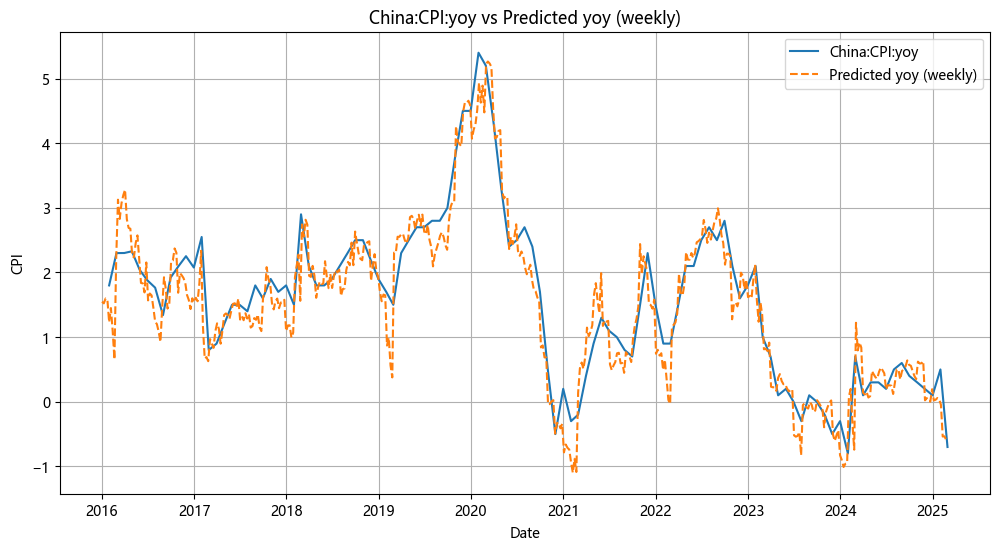

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(df_result.index[12:], df_result["中国:CPI:当月同比"].iloc[12:], label="China:CPI:yoy", linestyle='-')
plt.plot(df_merged_weekly["Date"], df_merged_weekly["预测CPI当周同比"], label="Predicted yoy (weekly)", linestyle='--')

# 设置图表标题和标签
plt.title("China:CPI:yoy vs Predicted yoy (weekly)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

# DTM calculation

In [163]:
df_pred = df_merged_weekly[['Date','预测CPI当周同比']]
df_pred

,Date,预测CPI当周同比
309,2016-01-03,1.548507
310,2016-01-10,1.522734
311,2016-01-17,1.598140
312,2016-01-24,1.584449
313,2016-01-31,1.231962
...,...,...
782,2025-01-26,0.039648
783,2025-02-02,-0.046395
784,2025-02-09,-0.537841
785,2025-02-16,-0.534753


In [165]:
from fastdtw import fastdtw
import matplotlib.dates as mdates
monthly_data = df_pred.groupby(pd.Grouper(key='Date', freq='M'))

# Define the function to calculate DTW distance
def calculate_dtw(series1, series2):
    # Calculate the DTW distance if both series have more than 1 point
    if len(series1) > 1 and len(series2) > 1:
        distance, _ = fastdtw(series1, series2)
        return distance
    else:
        return None  # Return None if the series is too short

# Initialize an empty dictionary to store the results
dtw_results = {}

# Loop over each variable (column) in the DataFrame, and calculate DTW for each
for i, variable in enumerate(df_pred.columns[1:]):  # Skip the 'date' column
    dtw_distances = []
    month_labels = []
    
    # Loop through each month starting from the second month (to compare with previous months)
    for end_month, end_data in monthly_data:
        if end_month <= pd.Timestamp('2025-01-31'):  # We want to compare until January 2025
            if end_month == pd.Timestamp('2025-01-31'):  # We are interested in January 2025
                # Get the time series for January 2025
                series1 = end_data[variable].values
                
                for start_month, start_data in monthly_data:
                    if start_month < end_month:  # Only compare with previous months
                        # Get the time series for the previous months
                        series2 = start_data[variable].values
                        distance = calculate_dtw(series1, series2)
                        if distance is not None:
                            dtw_distances.append(distance)
                            month_labels.append(start_month.strftime('%Y-%m'))  # Format the month label as 'yyyy-mm'

    # Add the results to the dictionary with the variable name as the key
    dtw_results[variable] = pd.Series(dtw_distances, index=month_labels)

# Convert the dictionary to a DataFrame
dtw_df = pd.DataFrame(dtw_results)

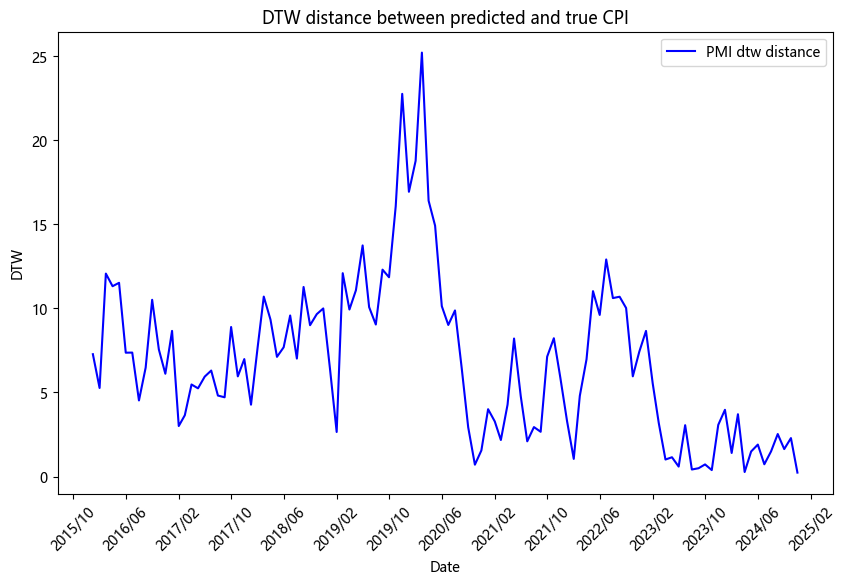

In [166]:
dtw_df.index = pd.to_datetime(dtw_df.index)

# 绘制真实值与预测值对比图
plt.figure(figsize=(10, 6))
plt.plot(dtw_df.index, dtw_df, label='PMI dtw distance', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('DTW')
plt.title('DTW distance between predicted and true CPI')
plt.legend()
# 设置日期格式：每三个月显示一次
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))  # 每个月显示年份-月份
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=8))  # 每三个月显示一次标签
# 自动旋转日期标签以避免重叠
plt.xticks(rotation=45)
plt.show()

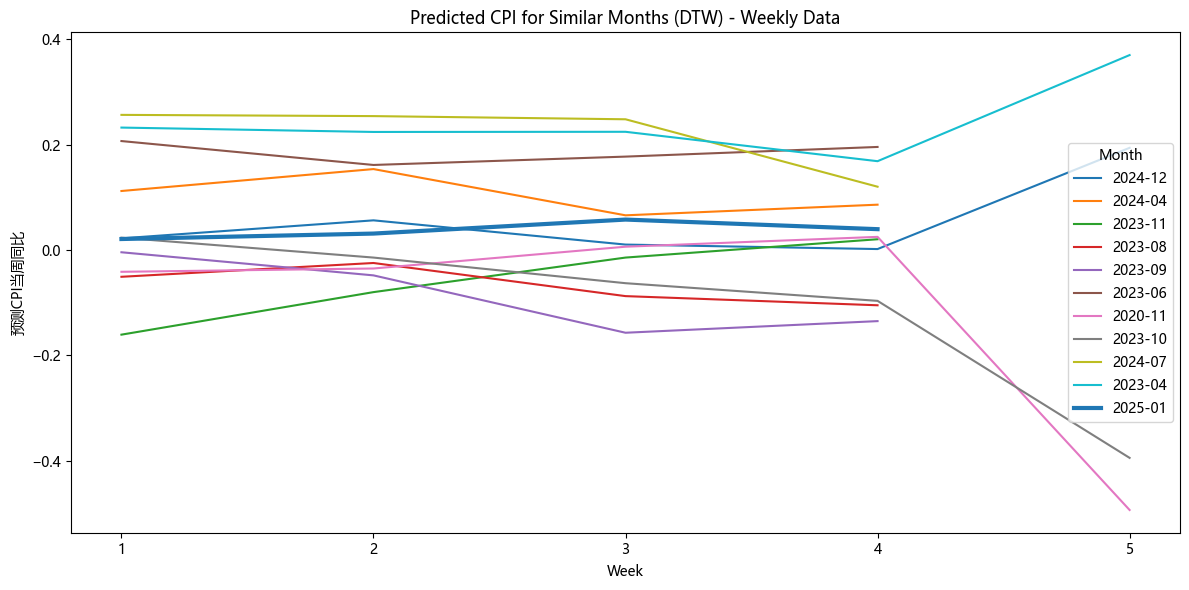

In [168]:
similar_dates = dtw_df.sort_values(by='预测CPI当周同比', ascending=True).head(10).index
similar_dates = similar_dates.append(pd.to_datetime(['2025-01-01']))

# 提取出年月
months = [(date.year, date.month) for date in similar_dates]

# 设置绘图
plt.figure(figsize=(12, 6))

# 遍历每个相似的年月
for year, month in months:
    # 筛选出该年月的数据
    month_data = df_pred[(df_pred['Date'].dt.year == year) & (df_pred['Date'].dt.month == month)]
    
    # 计算该月份的周次（1, 2, 3, 4, 5）
    month_data['Week'] = [i for i in range(1, len(month_data) + 1)]
    
    # 判断是否是2025年1月，并加粗
    if year == 2025 and month == 1:
        plt.plot(month_data['Week'], month_data['预测CPI当周同比'], label=f"{year}-{month:02d}", linewidth=3)  # 加粗线条
    else:
        plt.plot(month_data['Week'], month_data['预测CPI当周同比'], label=f"{year}-{month:02d}")

# 设置标题、标签和图例
plt.title('Predicted CPI for Similar Months (DTW) - Weekly Data')
plt.xlabel('Week')
plt.ylabel('预测CPI当周同比')
plt.legend(title="Month")
plt.xticks(range(1, 6))  # 横轴显示 1, 2, 3, 4, 5
plt.tight_layout()

# 显示图表
plt.show()

# Fit PPI using the similar way.

#### PPI data is what we have fiited, and we also merge them with overseas liquidity data(`USDCNH`,`10Y rate-10Y real rate`) and Chinese Monetary data(`Net Liquidity Injection`, `DR007 (7-day interbank pledged repo rate)`)

In [ ]:
# PPI data we have fitted
df_predicted_ppi = pd.read_excel(r'C:\QPS\Project\PPI.xlsx')
df_predicted_ppi = df_predicted_ppi[['Unnamed: 0','PPI YOY predicted']]
df_predicted_ppi = df_predicted_ppi.rename(columns={'Unnamed: 0':'Date'}).set_index('Date').resample('w').last()
df_predicted_ppi.fillna(method='ffill',inplace=True)
df_predicted_ppi

,PPI YOY predicted
Date,
2015-01-25,-3.542594
2015-02-01,-4.442787
2015-02-08,-4.595998
2015-02-15,-4.473732
2015-02-22,-4.665958
...,...
2025-01-19,-1.992039
2025-01-26,-2.056596
2025-02-02,-2.056596


In [224]:
# Overseas liquidity data： USDCNH and 10Y rate - 10Y real rate(inflation expectation)
df_oversea = pd.read_excel(r'C:\QPS\Overseas_Moetary.xlsx',skiprows=1)
df_oversea.rename(columns={'指标名称':'Date','即期汇率:美元兑离岸人民币(USDCNH)':'USDCNH','美国:国债收益率:10年-美国:国债实际收益率:10年':'10Y rate-10Y real rate'},inplace=True)
df_oversea = df_oversea.set_index('Date').resample('w').mean().dropna().reset_index()
df_oversea

,Date,USDCNH,10Y rate-10Y real rate
0,2012-05-06,6.30294,2.2380
1,2012-05-13,6.31192,2.1500
2,2012-05-20,6.32338,2.0940
3,2012-05-27,6.33454,2.1480
4,2012-06-03,6.35758,2.0850
...,...,...,...
668,2025-02-23,7.26166,2.4425
669,2025-03-02,7.27450,2.3820
670,2025-03-09,7.25610,2.3440
671,2025-03-16,7.24344,2.3080


In [226]:
df_monetary = pd.read_excel(r'C:\QPS\Monetary.xlsx',skiprows=1)
df_monetary.rename(columns={'指标名称':'Date','中国:公开市场操作:货币净投放:周:结束日7':'Net Liquidity Injection','DR007:周:合计值:结束日7':'DR007'},inplace=True)
df_monetary.dropna(inplace=True)
df_monetary

,Date,Net Liquidity Injection,DR007
560,2015-01-25,500.0,19.5206
561,2015-02-01,550.0,19.8823
562,2015-02-08,900.0,22.1832
563,2015-02-15,2050.0,27.2264
565,2015-03-01,-1420.0,19.0282
...,...,...,...
1085,2025-02-23,4818.0,10.7379
1086,2025-03-02,1369.7,10.9641
1087,2025-03-09,-8813.0,8.9930
1088,2025-03-16,-2517.0,9.0386


In [227]:
display(df_predicted_pmi)
display(df_predicted_cpi)
display(df_predicted_ppi)
display(df_oversea)
display(df_monetary)

,Date,Predicted PMI
0,2016-03-06,49.459114
1,2016-03-13,49.458889
2,2016-03-20,50.164883
3,2016-03-27,50.199635
4,2016-04-03,50.199623
...,...,...
460,2024-12-29,50.099258
461,2025-01-05,49.385448
462,2025-01-12,49.102264
463,2025-01-19,49.100449


,Date,预测CPI当周同比
309,2016-01-03,1.548507
310,2016-01-10,1.522734
311,2016-01-17,1.598140
312,2016-01-24,1.584449
313,2016-01-31,1.231962
...,...,...
782,2025-01-26,0.039648
783,2025-02-02,-0.046395
784,2025-02-09,-0.537841
785,2025-02-16,-0.534753


,PPI YOY predicted
Date,
2015-01-25,-3.542594
2015-02-01,-4.442787
2015-02-08,-4.595998
2015-02-15,-4.473732
2015-02-22,-4.665958
...,...
2025-01-19,-1.992039
2025-01-26,-2.056596
2025-02-02,-2.056596


,Date,USDCNH,10Y rate-10Y real rate
0,2012-05-06,6.30294,2.2380
1,2012-05-13,6.31192,2.1500
2,2012-05-20,6.32338,2.0940
3,2012-05-27,6.33454,2.1480
4,2012-06-03,6.35758,2.0850
...,...,...,...
668,2025-02-23,7.26166,2.4425
669,2025-03-02,7.27450,2.3820
670,2025-03-09,7.25610,2.3440
671,2025-03-16,7.24344,2.3080


,Date,Net Liquidity Injection,DR007
560,2015-01-25,500.0,19.5206
561,2015-02-01,550.0,19.8823
562,2015-02-08,900.0,22.1832
563,2015-02-15,2050.0,27.2264
565,2015-03-01,-1420.0,19.0282
...,...,...,...
1085,2025-02-23,4818.0,10.7379
1086,2025-03-02,1369.7,10.9641
1087,2025-03-09,-8813.0,8.9930
1088,2025-03-16,-2517.0,9.0386


In [ ]:
# we get the predicted data for CPI, PPI, Oversea liquidity and Monetary data
df_macro = df_predicted_pmi.merge(df_predicted_cpi, left_on='Date', right_on='Date', how='left')
df_macro = df_macro.merge(df_predicted_ppi, left_on='Date', right_on='Date', how='left')
df_macro = df_macro.merge(df_oversea, left_on='Date', right_on='Date', how='left')
df_macro = df_macro.merge(df_monetary, left_on='Date', right_on='Date', how='left')
df_macro = df_macro.fillna(method='ffill').dropna()

##### After we prepare our dataset, we use DTW to measure the distance between any two Months

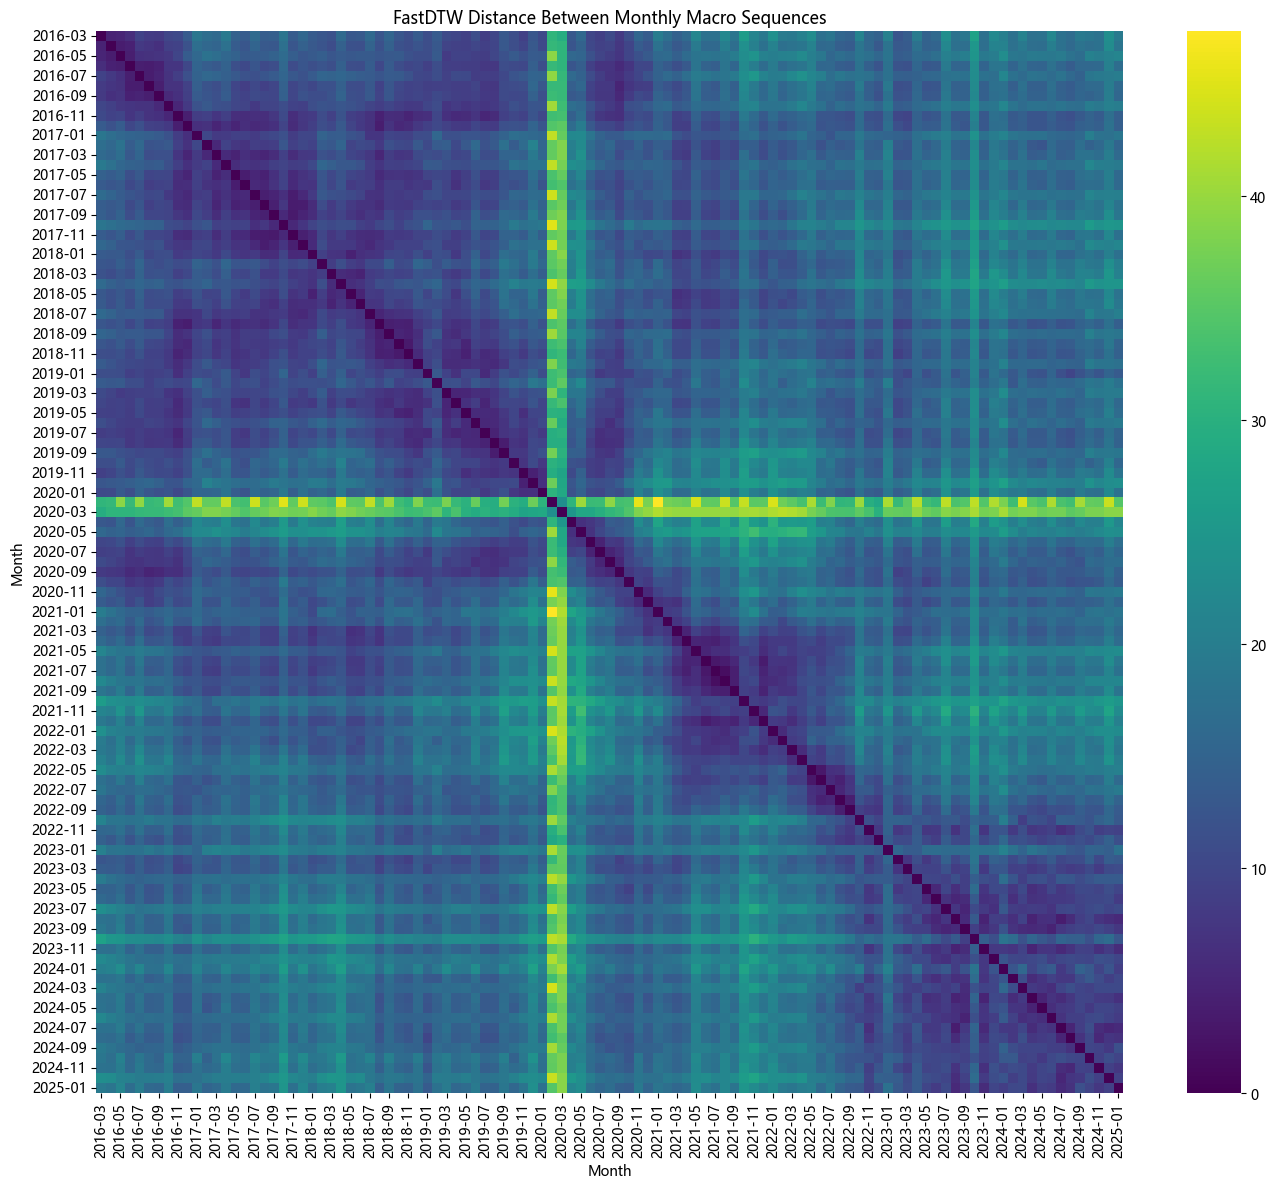

In [ ]:
import pandas as pd
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


df_macro['Date'] = pd.to_datetime(df_macro['Date'])

# 2. 标准化所有变量（排除 Date 列）
scaler = StandardScaler()
features = df_macro.columns.difference(['Date'])
df_macro_scaled = df_macro.copy()
df_macro_scaled[features] = scaler.fit_transform(df_macro[features])

# 3. 添加 YearMonth 列，按月分组
df_macro_scaled['YearMonth'] = df_macro_scaled['Date'].dt.to_period('M')
monthly_groups = df_macro_scaled.groupby('YearMonth')

# 4. 提取每个月的多维时间序列（每周是一个向量）
monthly_series = {}
for ym, group in monthly_groups:
    # 每周为一个多维点（去掉 Date 和 YearMonth）
    sequence = group[features].values
    monthly_series[ym] = sequence

# 5. 计算每对月份之间的 fastdtw 距离
months = list(monthly_series.keys())
n = len(months)
dist_matrix = pd.DataFrame(np.zeros((n, n)), index=months, columns=months)

for i in range(n):
    for j in range(i, n):
        seq_i = monthly_series[months[i]]
        seq_j = monthly_series[months[j]]
        distance, _ = fastdtw(seq_i, seq_j, dist=euclidean)
        dist_matrix.iloc[i, j] = distance
        dist_matrix.iloc[j, i] = distance  # 对称

# 6. 可视化 DTW 距离矩阵
plt.figure(figsize=(14, 12))
sns.heatmap(cc.astype(float), cmap='viridis')
plt.title("FastDTW Distance Between Monthly Macro Sequences")
plt.xlabel("Month")
plt.ylabel("Month")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Backtest

We conduct the backtest in the following order:
1. We first use the Wind API to obtain the monthly return data of the CSI 300 Index.

2. Then, using the DTW (Dynamic Time Warping) distances calculated between different months, we identify, for each month, the five most similar historical months based on the smallest DTW distances.

3. For each of these similar months, we look at the CSI 300 return in the following month.

4. These returns are then combined using a weighted average, where the weights are the inverse of the DTW distances.

5. If the resulting weighted return is greater than zero, we take a long position in the market; if it is less than or equal to zero, we stay in cash (no position).

6. This strategy is then backtested to evaluate its performance.

In [237]:
from WindPy import w
w.start() # Start the Wind API
data = w.wsd("000300.SH", "pct_chg", "2016-01-03", "2025-03-15", "Period=M;Days=Alldays;PriceAdj=F") # Get the daily percentage change of the CSI 300 index
df_hs300 = pd.DataFrame(data.Data, index=data.Fields, columns=data.Times).T
df_hs300 = df_hs300.reset_index().rename(columns={'index':'Date','PCT_CHG':'HS300:Weekly Return'}) # Reset the index and rename the columns
df_hs300['Date'] = pd.to_datetime(df_hs300['Date']) # Convert the '日期' column to datetime
df_hs300

,Date,HS300:Weekly Return
0,2016-01-31,-21.037618
1,2016-02-29,-2.329311
2,2016-03-31,11.837541
3,2016-04-30,-1.906188
4,2016-05-31,0.405947
...,...,...
106,2024-11-30,0.656472
107,2024-12-31,0.467951
108,2025-01-31,-2.994495
109,2025-02-28,1.911631


In [ ]:
top_k = 5  # for each month, find the top 5 most similar months
dtw_df = dist_matrix.copy()  

# prepare the HS300 weekly return data
df_hs300['Date'] = pd.to_datetime(df_hs300['Date'])
df_hs300['YearMonth'] = df_hs300['Date'].dt.to_period('M')
returns = df_hs300.set_index('YearMonth')['HS300:Weekly Return']


position_list = []

# iterate over each month
all_months = sorted(dtw_df.index)

for i, current_month in enumerate(all_months):
    # get the history months (before the current month)
    history_months = all_months[:i]

    if len(history_months) < top_k:
        continue  

    # get the DTW distances between the current month and history months
    distances = dtw_df.loc[current_month, history_months]
    distances = distances[distances > 0]  # remove 0 distances

    # get the top k most similar months
    nearest = distances.nsmallest(top_k)

    # calculate the weighted average return
    weighted_returns = []
    weights = []

    for past_month, dist in nearest.items():
        next_month = past_month + 1
        if next_month in returns.index:
            r = returns.loc[next_month]
            w = 1 / dist
            weighted_returns.append(r * w)
            weights.append(w)

    # calculate the weighted average return
    if weights:
        weighted_avg_return = sum(weighted_returns) / sum(weights)
        position_list.append({
            'Date': current_month.to_timestamp(how='end'),
            'return': weighted_avg_return
        })

# convert the list of positions to a DataFrame
df_position = pd.DataFrame(position_list)
df_position.reset_index(drop=True, inplace=True)
df_position['Date'] = df_position['Date'].dt.strftime('%Y-%m-%d')

In [249]:
df_position.to_excel('df_position.xlsx')
df_position

,Date,return
0,2016-08-31,1.277253
1,2016-09-30,0.604725
2,2016-10-31,1.172664
3,2016-11-30,2.582974
4,2016-12-31,-0.913328
...,...,...
97,2024-09-30,3.737846
98,2024-10-31,-1.495735
99,2024-11-30,3.496656
100,2024-12-31,1.867870


In [252]:
from backtestlib import *
from datetime import datetime,date
import pandas as pd
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
start_date_true= '2017-01-01' #期望开始时间
end_date= '2025-02-28'
# end_date = '2024-12-31'
# end_date = '2024-11-20'
transaction_fee_rate=0.0003 # 交易费率为0.03%
index_code = '000300.SH' # 指数代码
def int_index_to_datetime(df):
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    return df

def adj_date(df, start_date=start_date_true, end_date=end_date):
    try:
        return df[(df.index>=start_date) & (df.index<=end_date)]
    except:
        raise Exception('Date must be integer and set as index.')

In [257]:
# load the data
df_position = pd.read_excel(r'C:\QPS\df_position.xlsx')
df_position.drop(columns=['Unnamed: 0'], inplace=True)
df_position['Date'] = pd.to_datetime(df_position['Date'])  # 确保是 datetime 类型
# df_position['Date'] = df_position['Date'].dt.to_period('M').dt.to_timestamp()
for i in range(len(df_position)):
    if df_position.loc[i, 'return'] >= 0:
        df_position.loc[i, 'Position'] = 1
    if df_position.loc[i, 'return'] < 0:
        df_position.loc[i, 'Position'] = 0
df_longshort = df_position.set_index('Date').copy()
df_longshort

,return,Position
Date,,
2016-08-31,1.277253,1.0
2016-09-30,0.604725,1.0
2016-10-31,1.172664,1.0
2016-11-30,2.582974,1.0
2016-12-31,-0.913328,0.0
...,...,...
2024-09-30,3.737846,1.0
2024-10-31,-1.495735,0.0
2024-11-30,3.496656,1.0


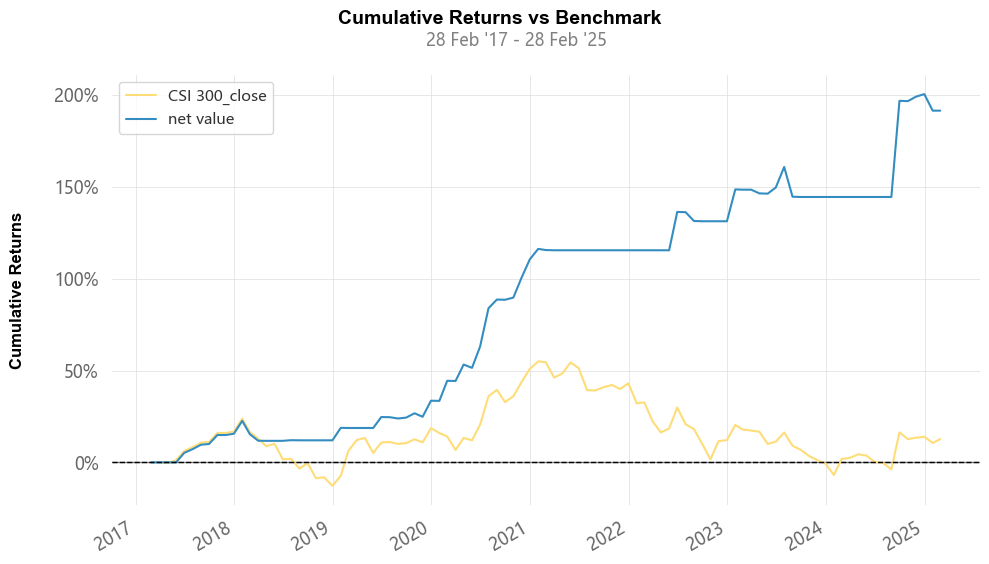

,2017,2018,2019,2020,2021,2022,2023,2024,2025,Full Period
Annualized Return,0.126719,-0.023432,0.142075,0.408358,0.017652,0.054875,0.042810,0.167852,-0.239381,0.096686
Annualized Volatility,0.300214,0.430555,0.453220,0.686721,0.125809,0.462182,0.511570,0.977157,0.336131,0.562683
Information Ratio,-0.187253,0.558845,-0.240845,0.521812,0.177351,0.451125,0.829332,0.134706,-0.707107,0.246357
Win Rate,0.750000,0.333333,0.555556,0.666667,0.333333,0.250000,0.375000,0.750000,0.000000,0.527273
Maximum Drawdown Rate,-0.000154,-0.088809,-0.014943,-0.011643,-0.003439,-0.021438,-0.062676,-0.000600,0.000000,-0.088809
Excess Net Value,-0.011516,0.222161,-0.168168,0.304394,0.075449,0.289700,0.170915,0.082255,-0.018544,1.789214
Annualized Excess Return,-0.008279,0.198377,-0.115345,0.167489,0.049595,0.230287,0.137350,0.041090,-0.159462,0.072986
Excess Drawdown Level,-0.015446,-0.031297,-0.202402,-0.017327,-0.054890,-0.102490,-0.002731,-0.116088,-0.019116,-0.204683
Return Volatility Ratio,0.422095,-0.054422,0.313479,0.594650,0.140306,0.118730,0.083684,0.171776,-0.712164,0.171831
Return Drawdown Ratio,-820.767941,0.263843,-9.507549,-35.073407,-5.132738,-2.559759,-0.683041,-279.754100,NaN,-1.088693


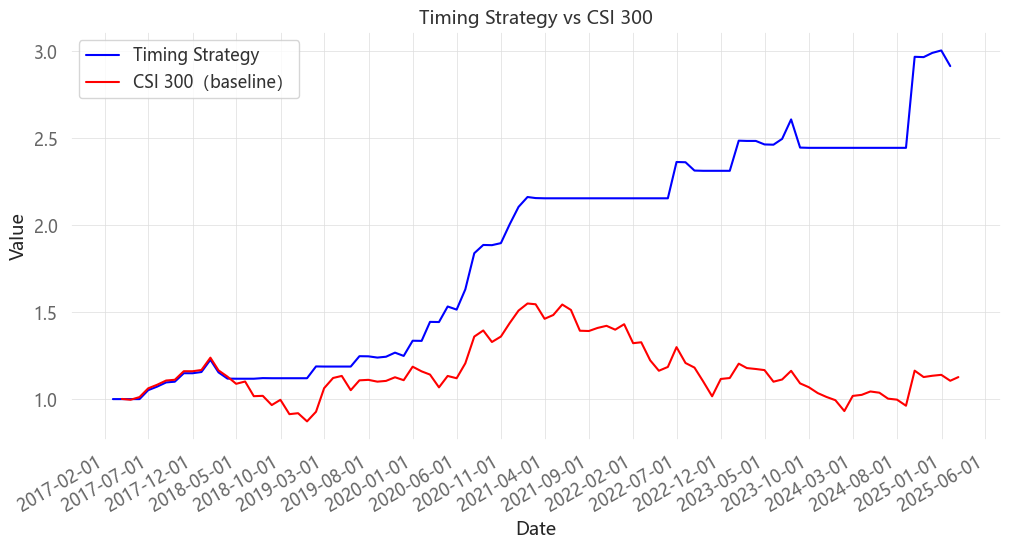

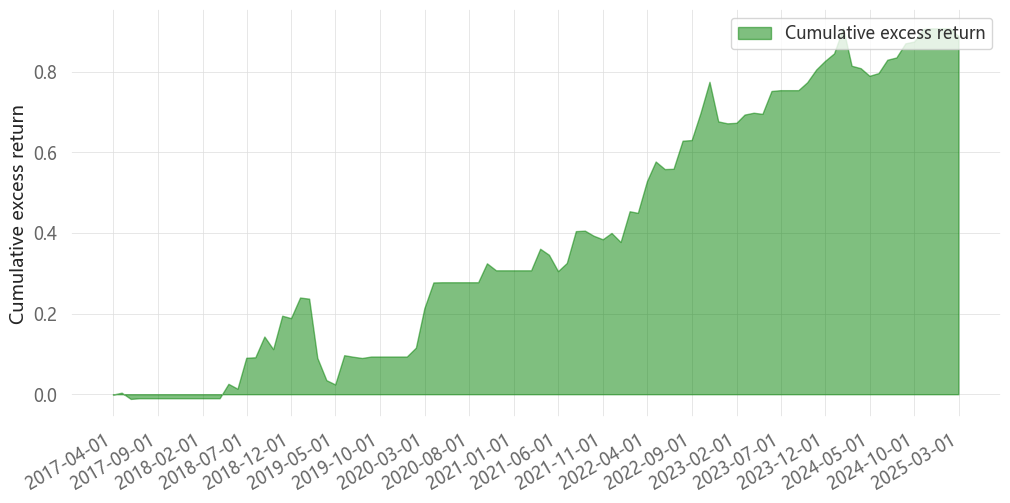

In [258]:
df_longshort['transaction_fee']=0.0 #初始化交易费用为0
# 计算仓位变动
for i in range(1, len(df_longshort)):
    previous_position = df_longshort.iloc[i-1]['Position']
    current_position = df_longshort.iloc[i]['Position']
    
    # 计算交易费用
    if previous_position != current_position:
        df_longshort['transaction_fee'].iloc[i] = transaction_fee_rate  * abs(current_position - previous_position)
        # df_longshort['transaction_fee'].iloc[i] = transaction_fee_rate
    else:
        df_longshort['transaction_fee'].iloc[i] = 0
    
strategy_longshort = backtest_longshort(start_date='2017-02-01', end_date=end_date,df_timing = df_longshort, index_code=index_code,positive = 0)
# strategy_longshort = backtest_longshort(start_date='2022-01-01', end_date=end_date,df_timing = df_longshort, index_code=index_code,positive = 0)
# 策略收益率和基准收益率
strategy_returns = strategy_longshort.df_merged['net value'].pct_change(1)
benchmark_returns = strategy_longshort.df_merged[f'{strategy_longshort.get_index_name(strategy_longshort.index_code)}_close'].pct_change(1)
risk_free_rate = 0.02  # 假设年化无风险利率为2%

# 调用analyze_performance方法来分析表现
performance_metrics = strategy_longshort.analyze_performance(strategy_returns, benchmark_returns, risk_free_rate)
result = strategy_longshort.calculate_performance()
result